重新写预处理操作，数据集不大，转为numpy文件就行。要不然每次读取图片太慢了，GPU利用率也不高

In [2]:
import cv2
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
origin_dir = './origin_datasets'
datasets_dir = './datasets'
dataset = 'ISIC'

In [4]:
origin_dataset = os.path.join(origin_dir,dataset)
target_dataset = os.path.join(datasets_dir,dataset)
print(origin_dataset,target_dataset)

./origin_datasets/ISIC ./datasets/ISIC


In [5]:
if not os.path.exists(target_dataset):
    os.makedirs(target_dataset)
if not os.path.exists(os.path.join(target_dataset,'images')):
    os.makedirs(os.path.join(target_dataset,'images'))    
if not os.path.exists(os.path.join(target_dataset,'masks')):
    os.makedirs(os.path.join(target_dataset,'masks'))

In [6]:
# Data loading code
img_ids = glob(os.path.join(origin_dataset, 'images', '*'))
img_ids[0]

'./origin_datasets/ISIC/images/ISIC_0000025.jpg'

In [7]:
mask_ids = []
for img_id in img_ids:
    img_name = img_id.split('/')[-1].split('.')[0] # ISIC_0008256
    # mask_ids.append(os.path.join(origin_dataset, 'masks', '0', img_name+'_segmentation.png'))
    mask_ids.append(os.path.join(origin_dataset, 'masks', img_name+'_segmentation.png'))
print(img_ids[64],mask_ids[64])

./origin_datasets/ISIC/images/ISIC_0015206.jpg ./origin_datasets/ISIC/masks/ISIC_0015206_segmentation.png


## process

做归一化，也做resize

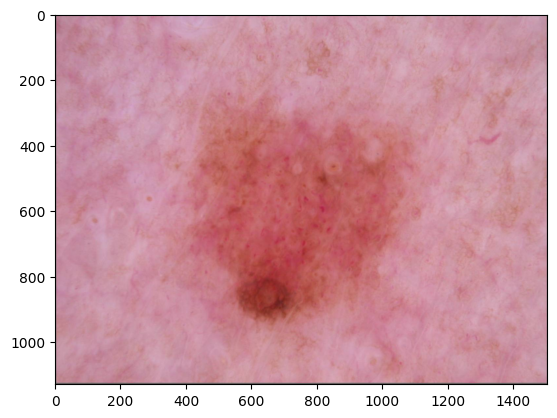

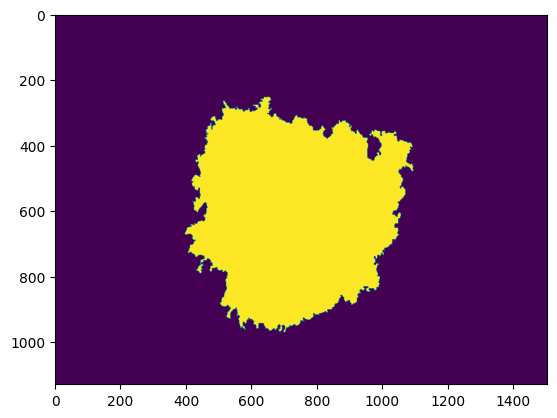

(1129, 1504, 3) (1129, 1504) 255 0 1.0 0.0


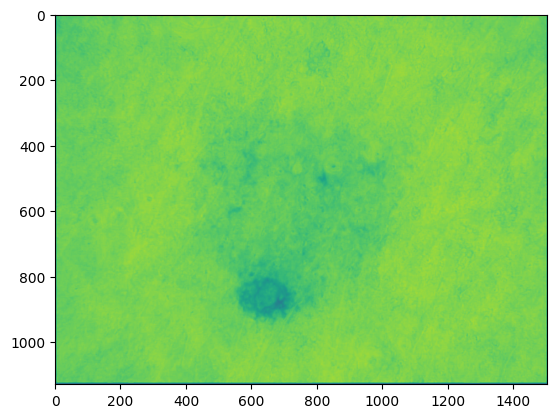

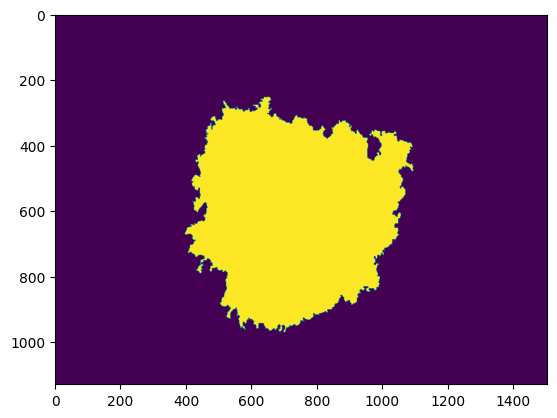

(3, 1129, 1504) (1, 1129, 1504) 1.0 0.0 1.0 0.0


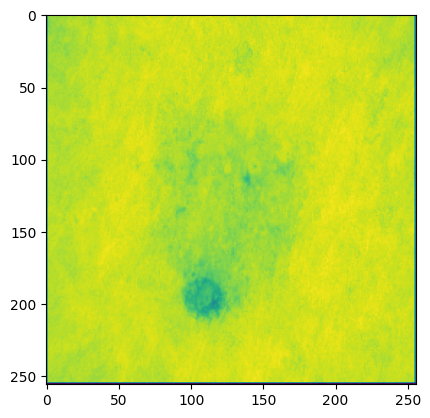

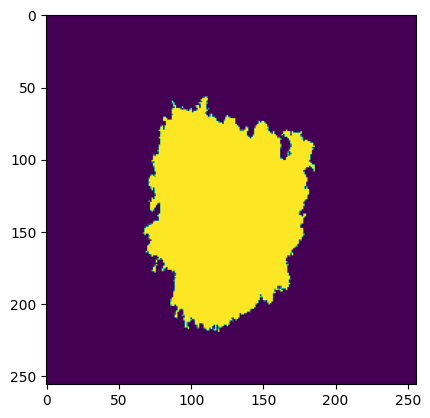

(3, 256, 256) (1, 256, 256) 0.8668744 0.0 1.0 0.0


In [8]:
img = plt.imread(img_ids[0])
plt.imshow(img)
plt.show()

mask = plt.imread(mask_ids[0])
plt.imshow(mask)
plt.show()

print( img.shape,mask.shape,img.max(),img.min(),mask.max(),mask.min() )

img = img.transpose(2,0,1)/255.0
H,W = mask.shape
mask = mask.reshape(1,H,W)

plt.imshow(img[0])
plt.show()

plt.imshow(mask[0])
plt.show()
print( img.shape,mask.shape,img.max(),img.min(),mask.max(),mask.min() )


upsample = nn.Upsample(size=(256), mode='bilinear',align_corners=False)
img,mask = torch.Tensor(img).unsqueeze(0),torch.Tensor(mask).unsqueeze(0)
img,mask = upsample(img).squeeze(0).numpy(),upsample(mask).squeeze(0).numpy()

plt.imshow(img[0])
plt.show()

plt.imshow(mask[0])
plt.show()
print( img.shape,mask.shape,img.max(),img.min(),mask.max(),mask.min() )

In [9]:
from skimage import measure
import cv2
from skimage import feature
mask_2d = (mask[0] == 1)
contours = measure.find_contours(mask_2d, 0.5)
if len(contours) > 1:
    contours = [contours[0]]
contours = np.array(contours)
contours1 = contours.copy()
contours1[:,:,1] = contours[:,:,0]
contours1[:,:,0] = contours[:,:,1]

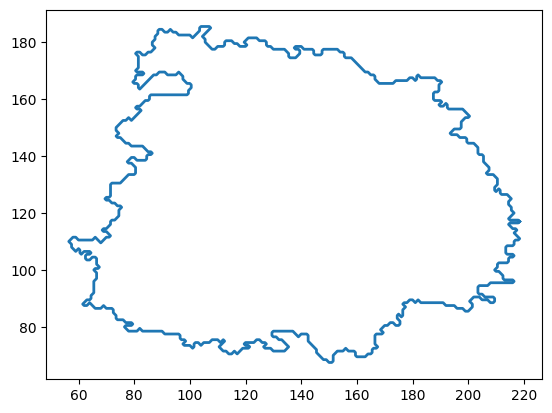

In [10]:
for contour in contours1:
    plt.plot(contour[:,1],contour[:,0],linewidth=2)
    plt.show()

In [11]:
def draw_min_rect_rectangle(mask):
    c_list,h_list,w_list = np.where(mask == 255)
    x_min = np.min(w_list)
    x_max = np.max(w_list)
    
    y_min = np.min(h_list)
    y_max = np.max(h_list)
    
#     return ((x_min,y_min),(x_max,y_min),(x_max,y_max),(x_min,y_max))
    return ((x_min,y_min),x_max-x_min,y_max-y_min)

In [12]:
mask_uint = np.array(mask*255,dtype=np.uint8)
print( mask_uint.max(),mask_uint.min() )
print(mask.shape)
min_rect = draw_min_rect_rectangle(mask_uint)

255 0
(1, 256, 256)


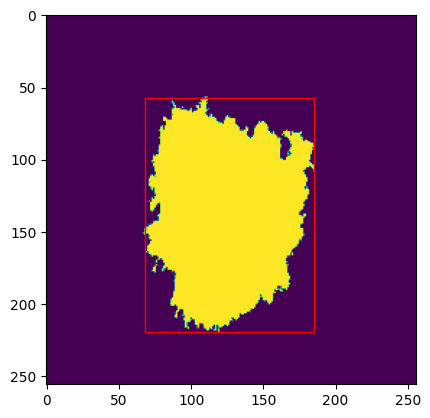

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
 
fig, ax = plt.subplots()
ax.imshow(mask[0])
min_rect = draw_min_rect_rectangle(mask_uint)
(x, y), width, height = min_rect
# 创建一个矩形，参数为(x, y, width, height)
rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
 
# 将矩形添加到子图中
ax.add_patch(rect)
plt.show()

Rectangle(xy=(68, 57), width=117, height=162, angle=0)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


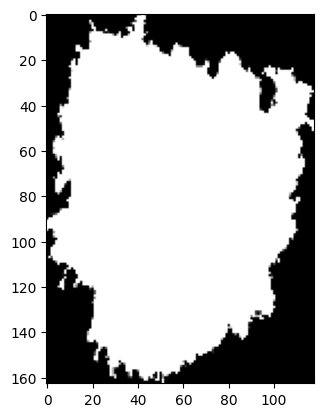

In [14]:
print(rect)
print(mask[0][y:y+height,x:x+width])
plt.imshow(mask[0][y:y+height+1,x:x+width+1],cmap='gray')
plt.show()

In [15]:
img_HWC = img.transpose(1,2,0)
mask_HWC = mask.transpose(1,2,0)
data = {
    'image': mask_HWC,
    'polys':np.array([
        [[x,y],[x+width,y],[x+width,y+height],[x,y+height]]
    ]),
}
data = {
    'image': mask_HWC,
    'polys':contours1,
}

In [15]:
import numpy as np
import cv2

np.seterr(divide='ignore', invalid='ignore')
import pyclipper
from shapely.geometry import Polygon
import sys
import warnings

warnings.simplefilter("ignore")

# 计算文本区域阈值图标签类
# 详细实现代码参考：https://github.com/PaddlePaddle/PaddleOCR/blob/release%2F2.4/ppocr/data/imaug/make_border_map.py
class MakeBorderMap(object):
    def __init__(self,
                 shrink_ratio=0.4,
                 thresh_min=0.3,
                 thresh_max=0.7,
                 **kwargs):
        self.shrink_ratio = shrink_ratio
        self.thresh_min = thresh_min
        self.thresh_max = thresh_max

    def __call__(self, data):

        img = data['image']
        text_polys = data['polys']

        # 1. 生成空模版
        canvas = np.zeros(img.shape[:2], dtype=np.float32)
        mask = np.zeros(img.shape[:2], dtype=np.float32)

        for i in range(len(text_polys)):

            # 2. draw_border_map函数根据解码后的box信息计算阈值图标签
            self.draw_border_map(text_polys[i], canvas, mask=mask)
        canvas = canvas * (self.thresh_max - self.thresh_min) + self.thresh_min

        data['threshold_map'] = canvas
        data['threshold_mask'] = mask
        return data
    
    def draw_border_map(self, polygon, canvas, mask):
        polygon = np.array(polygon)
        assert polygon.ndim == 2
        assert polygon.shape[1] == 2

        polygon_shape = Polygon(polygon)
        if polygon_shape.area <= 0:
            return
        distance = polygon_shape.area * (
            1 - np.power(self.shrink_ratio, 2)) / polygon_shape.length
        subject = [tuple(l) for l in polygon]
        padding = pyclipper.PyclipperOffset()
        padding.AddPath(subject, pyclipper.JT_ROUND, pyclipper.ET_CLOSEDPOLYGON)

        padded_polygon = np.array(padding.Execute(distance)[0])
        cv2.fillPoly(mask, [padded_polygon.astype(np.int32)], 1.0)

        xmin = padded_polygon[:, 0].min()
        xmax = padded_polygon[:, 0].max()
        ymin = padded_polygon[:, 1].min()
        ymax = padded_polygon[:, 1].max()
        width = xmax - xmin + 1
        height = ymax - ymin + 1

        polygon[:, 0] = polygon[:, 0] - xmin
        polygon[:, 1] = polygon[:, 1] - ymin

        xs = np.broadcast_to(
            np.linspace(
                0, width - 1, num=width).reshape(1, width), (height, width))
        ys = np.broadcast_to(
            np.linspace(
                0, height - 1, num=height).reshape(height, 1), (height, width))

        distance_map = np.zeros(
            (polygon.shape[0], height, width), dtype=np.float32)
        for i in range(polygon.shape[0]):
            j = (i + 1) % polygon.shape[0]
            absolute_distance = self._distance(xs, ys, polygon[i], polygon[j])
            distance_map[i] = np.clip(absolute_distance / distance, 0, 1)
        distance_map = distance_map.min(axis=0)

        xmin_valid = min(max(0, xmin), canvas.shape[1] - 1)
        xmax_valid = min(max(0, xmax), canvas.shape[1] - 1)
        ymin_valid = min(max(0, ymin), canvas.shape[0] - 1)
        ymax_valid = min(max(0, ymax), canvas.shape[0] - 1)
        canvas[ymin_valid:ymax_valid + 1, xmin_valid:xmax_valid + 1] = np.fmax(
            1 - distance_map[ymin_valid - ymin:ymax_valid - ymax + height,
                             xmin_valid - xmin:xmax_valid - xmax + width],
            canvas[ymin_valid:ymax_valid + 1, xmin_valid:xmax_valid + 1])

    def _distance(self, xs, ys, point_1, point_2):
        '''
        compute the distance from point to a line
        ys: coordinates in the first axis
        xs: coordinates in the second axis
        point_1, point_2: (x, y), the end of the line
        '''
        height, width = xs.shape[:2]
        square_distance_1 = np.square(xs - point_1[0]) + np.square(ys - point_1[
            1])
        square_distance_2 = np.square(xs - point_2[0]) + np.square(ys - point_2[
            1])
        square_distance = np.square(point_1[0] - point_2[0]) + np.square(
            point_1[1] - point_2[1])

        cosin = (square_distance - square_distance_1 - square_distance_2) / (
            2 * np.sqrt(square_distance_1 * square_distance_2))
        square_sin = 1 - np.square(cosin)
        square_sin = np.nan_to_num(square_sin)
        result = np.sqrt(square_distance_1 * square_distance_2 * square_sin /
                         square_distance)

        result[cosin <
               0] = np.sqrt(np.fmin(square_distance_1, square_distance_2))[cosin
                                                                           < 0]
        # self.extend_line(point_1, point_2, result)
        return result

    def extend_line(self, point_1, point_2, result, shrink_ratio):
        ex_point_1 = (int(
            round(point_1[0] + (point_1[0] - point_2[0]) * (1 + shrink_ratio))),
                      int(
                          round(point_1[1] + (point_1[1] - point_2[1]) * (
                              1 + shrink_ratio))))
        cv2.line(
            result,
            tuple(ex_point_1),
            tuple(point_1),
            4096.0,
            1,
            lineType=cv2.LINE_AA,
            shift=0)
        ex_point_2 = (int(
            round(point_2[0] + (point_2[0] - point_1[0]) * (1 + shrink_ratio))),
                      int(
                          round(point_2[1] + (point_2[1] - point_1[1]) * (
                              1 + shrink_ratio))))
        cv2.line(
            result,
            tuple(ex_point_2),
            tuple(point_2),
            4096.0,
            1,
            lineType=cv2.LINE_AA,
            shift=0)
        return ex_point_1, ex_point_2

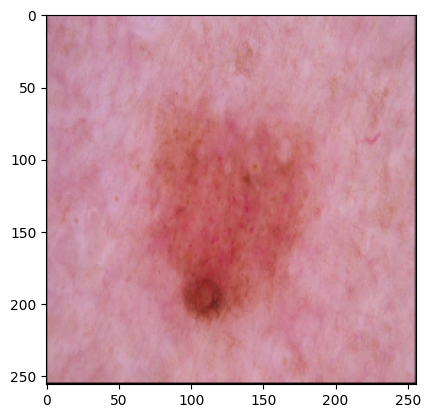

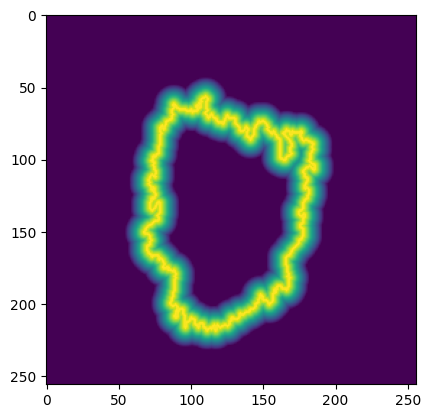

In [16]:
generate_text_border = MakeBorderMap()
data = generate_text_border(data)

plt.imshow(img_HWC)
plt.show()
threshold_map = data['threshold_map'].reshape(1,256,256)
plt.imshow(threshold_map.transpose(1,2,0))
plt.show()

In [17]:
import numpy as np
import cv2
from shapely.geometry import Polygon
import pyclipper

class MakeShrinkMap(object):

    def __init__(self, min_text_size=8, shrink_ratio=0.4, **kwargs):
        self.min_text_size = min_text_size
        self.shrink_ratio = shrink_ratio

    def __call__(self, data):
        image = data['image']
        text_polys = data['polys']

        h, w = image.shape[:2]
        text_polys = self.validate_polygons(text_polys, h, w)
        gt = np.zeros((h, w), dtype=np.float32)
        mask = np.ones((h, w), dtype=np.float32)
        for i in range(len(text_polys)):
            polygon = text_polys[i]
            height = max(polygon[:, 1]) - min(polygon[:, 1])
            width = max(polygon[:, 0]) - min(polygon[:, 0])


            polygon_shape = Polygon(polygon)
            subject = [tuple(l) for l in polygon]
            padding = pyclipper.PyclipperOffset()
            padding.AddPath(subject, pyclipper.JT_ROUND,
                            pyclipper.ET_CLOSEDPOLYGON)
            shrinked = []

            # Increase the shrink ratio every time we get multiple polygon returned back
            possible_ratios = np.arange(self.shrink_ratio, 1,
                                        self.shrink_ratio)
            np.append(possible_ratios, 1)
            for ratio in possible_ratios:
                distance = polygon_shape.area * (
                    1 - np.power(ratio, 2)) / polygon_shape.length
                shrinked = padding.Execute(-distance)
                if len(shrinked) == 1:
                    break

            if shrinked == []:
                cv2.fillPoly(mask,
                             polygon.astype(np.int32)[np.newaxis, :, :], 0)
                ignore_tags[i] = True
                continue

            for each_shirnk in shrinked:
                shirnk = np.array(each_shirnk).reshape(-1, 2)
                cv2.fillPoly(gt, [shirnk.astype(np.int32)], 1)

        data['shrink_map'] = gt
        data['shrink_mask'] = mask
        return data

    def validate_polygons(self, polygons, h, w):
        '''
        polygons (numpy.array, required): of shape (num_instances, num_points, 2)
        '''
        if len(polygons) == 0:
            return polygons

        for polygon in polygons:
            polygon[:, 0] = np.clip(polygon[:, 0], 0, w - 1)
            polygon[:, 1] = np.clip(polygon[:, 1], 0, h - 1)

        for i in range(len(polygons)):
            area = self.polygon_area(polygons[i])
            if area > 0:
                polygons[i] = polygons[i][::-1, :]
        return polygons

    def polygon_area(self, polygon):
        """
        compute polygon area
        """
        area = 0
        q = polygon[-1]
        for p in polygon:
            area += p[0] * q[1] - p[1] * q[0]
            q = p
        return area / 2.0

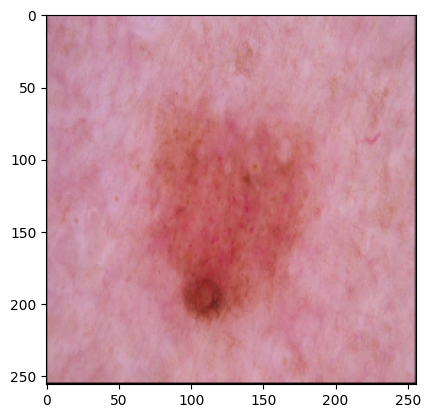

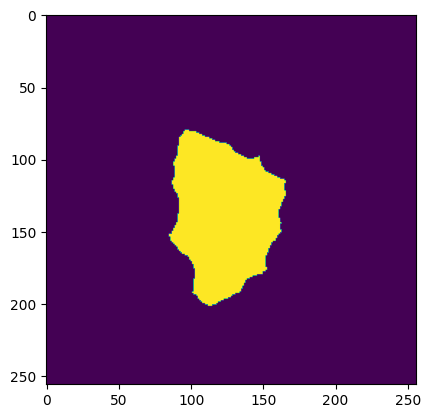

In [18]:
# 1. 声明文本概率图标签生成
generate_shrink_map = MakeShrinkMap(shrink_ratio=0.4)

# 2. 根据解码后的标签计算文本区域概率图
data = generate_shrink_map(data)

# 3. 文本区域概率图可视化

plt.imshow(img_HWC)
plt.show()
shrink_map = data['shrink_map']

plt.imshow(shrink_map)
plt.show()

In [19]:
from tqdm import tqdm
from PIL import ImageFile
from skimage import measure
ImageFile.LOAD_TRUNCATED_IMAGES = True
## 这么慢么？？？？？？不应该啊 1h09min 没有resize之前是这么慢，resize到512之后是25min
upsample = nn.Upsample(size=(256), mode='bilinear',align_corners=False)
generate_text_border = MakeBorderMap()
generate_shrink_map = MakeShrinkMap(shrink_ratio=0.4)
if not os.path.exists(target_dataset):
    os.makedirs(target_dataset)
if not os.path.exists(os.path.join(target_dataset,'images')):
    os.makedirs(os.path.join(target_dataset,'images'))    
if not os.path.exists(os.path.join(target_dataset,'masks')):
    os.makedirs(os.path.join(target_dataset,'masks'))
if not os.path.exists(os.path.join(target_dataset,'thresholds')):
    os.makedirs(os.path.join(target_dataset,'thresholds'))
if not os.path.exists(os.path.join(target_dataset,'shrinks')):
    os.makedirs(os.path.join(target_dataset,'shrinks'))
for index,img_id in enumerate(tqdm(img_ids)):
    img_name = img_id.split('/')[-1].split('.')[0] # ISIC_0008256
    img = plt.imread(img_id)
    mask = plt.imread(mask_ids[index])
    

    img = img.transpose(2,0,1) / 255.0     # 归一化
    H,W = mask.shape
    mask = mask.reshape(1,H,W)      # 加维度
    
    # resize
    img,mask = torch.Tensor(img).unsqueeze(0),torch.Tensor(mask).unsqueeze(0)
    img,mask = upsample(img).squeeze(0).numpy(),upsample(mask).squeeze(0).numpy()
    
    mask[mask >= 1e-10] = 1
    mask[mask < 1e-10] = 0

    # mask_2d = (mask[0] == 1)
    # contours = measure.find_contours(mask_2d, 0.5)
    # try:
    #     if len(contours) > 1:
    #         print('warning!: len(contours) gt 1 !,img_name:',img_name,'\t img_id:',index)
    #         contours = [contours[0]]
    #     contours = np.array(contours)
    # except:
    #     print('It is wrong!,contours:',contours,image)
    #     exit()
    # contours1 = contours.copy()
    # contours1[:,:,1] = contours[:,:,0]
    # contours1[:,:,0] = contours[:,:,1]

    # 换成cv2的更好
    contours,_=cv2.findContours(image=np.array(mask.transpose(1,2,0),dtype=np.uint8),mode=cv2.RETR_EXTERNAL,method=cv2.CHAIN_APPROX_NONE)  
    if len(contours) > 1:
        print('warning!: len(contours) gt 1 !,img_name:',img_name,'\t img_id:',index)
        max_length_idx = 0
        max_length = 0
        for i in range(len(contours)):
            if contours[i].shape[0] > max_length:
                max_length_idx = i
                max_length = contours[i].shape[0]
            print(max_length,max_length_idx,contours[i].shape) # check
        contours = contours[max_length_idx]
    else: contours = contours[0]
        
    contours = np.array(contours).transpose(1,0,2)
    contours1 = contours
    
    mask_HWC = mask.transpose(1,2,0)
    data = {
        'image': mask_HWC,
        'polys':contours1,
    }
    data = generate_text_border(data)
    data = generate_shrink_map(data)
    
    # save
    np.save(os.path.join(target_dataset,'images',img_name+'.npy'),img)
    np.save(os.path.join(target_dataset,'masks',img_name+'.npy'),mask)
    np.save(os.path.join(target_dataset,'thresholds',img_name+'.npy'),data['threshold_map'].reshape(1,256,256))
    np.save(os.path.join(target_dataset,'shrinks',img_name+'.npy'),data['shrink_map'].reshape(1,256,256))

  0%|          | 9/2594 [00:07<38:42,  1.11it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0001449 	 img_id: 8
2 0 (2, 1, 2)
267 1 (267, 1, 2)


  1%|          | 24/2594 [00:14<28:40,  1.49it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0010034 	 img_id: 24
1 0 (1, 1, 2)
701 1 (701, 1, 2)


  2%|▏         | 43/2594 [00:25<14:10,  3.00it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015986 	 img_id: 42
1 0 (1, 1, 2)
316 1 (316, 1, 2)
warning!: len(contours) gt 1 !,img_name: ISIC_0000421 	 img_id: 43
1 0 (1, 1, 2)
2 1 (2, 1, 2)
5 2 (5, 1, 2)
5 2 (1, 1, 2)
5 2 (1, 1, 2)
5 2 (2, 1, 2)
650 6 (650, 1, 2)


  2%|▏         | 46/2594 [00:27<20:55,  2.03it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000409 	 img_id: 45
1 0 (1, 1, 2)
299 1 (299, 1, 2)


  2%|▏         | 51/2594 [00:29<16:28,  2.57it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015945 	 img_id: 50
1 0 (1, 1, 2)
1 0 (1, 1, 2)
187 2 (187, 1, 2)


  2%|▏         | 64/2594 [00:34<16:36,  2.54it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015206 	 img_id: 64
2 0 (2, 1, 2)
2 0 (1, 1, 2)
2 0 (1, 1, 2)
2 0 (2, 1, 2)
2 0 (2, 1, 2)
2 0 (1, 1, 2)
615 6 (615, 1, 2)


  3%|▎         | 68/2594 [00:38<26:18,  1.60it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0001267 	 img_id: 67
6 0 (6, 1, 2)
331 1 (331, 1, 2)
331 1 (10, 1, 2)
warning!: len(contours) gt 1 !,img_name: ISIC_0000179 	 img_id: 68
2 0 (2, 1, 2)
4 1 (4, 1, 2)
4 1 (1, 1, 2)
973 3 (973, 1, 2)


  3%|▎         | 84/2594 [00:48<30:52,  1.35it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0010380 	 img_id: 84
7 0 (7, 1, 2)
565 1 (565, 1, 2)


  4%|▎         | 96/2594 [00:53<16:24,  2.54it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0016040 	 img_id: 95
1 0 (1, 1, 2)
2 1 (2, 1, 2)
6 2 (6, 1, 2)
6 2 (4, 1, 2)
6 2 (1, 1, 2)
275 5 (275, 1, 2)


  4%|▍         | 105/2594 [00:57<14:02,  2.96it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015950 	 img_id: 104
1 0 (1, 1, 2)
196 1 (196, 1, 2)


  4%|▍         | 111/2594 [01:00<14:40,  2.82it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015011 	 img_id: 111
2 0 (2, 1, 2)
2 0 (2, 1, 2)
7 2 (7, 1, 2)
7 2 (1, 1, 2)
7 2 (1, 1, 2)
1175 5 (1175, 1, 2)


  4%|▍         | 113/2594 [01:05<57:37,  1.39s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0013474 	 img_id: 113
1 0 (1, 1, 2)
2 1 (2, 1, 2)
2 1 (1, 1, 2)
593 3 (593, 1, 2)


  5%|▍         | 125/2594 [01:12<17:29,  2.35it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015987 	 img_id: 124
1 0 (1, 1, 2)
234 1 (234, 1, 2)


  5%|▍         | 127/2594 [01:12<16:25,  2.50it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014284 	 img_id: 126
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1 0 (1, 1, 2)
220 4 (220, 1, 2)


  5%|▌         | 133/2594 [01:14<11:03,  3.71it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015171 	 img_id: 133
2 0 (2, 1, 2)
6 1 (6, 1, 2)
6 1 (1, 1, 2)
6 1 (1, 1, 2)
6 1 (1, 1, 2)
1341 5 (1341, 1, 2)


  5%|▌         | 136/2594 [01:19<31:46,  1.29it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0012178 	 img_id: 135
2 0 (2, 1, 2)
4 1 (4, 1, 2)
47 2 (47, 1, 2)
47 2 (1, 1, 2)
709 4 (709, 1, 2)


  6%|▌         | 147/2594 [01:28<32:12,  1.27it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014910 	 img_id: 147
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1 0 (1, 1, 2)
2 3 (2, 1, 2)
2 3 (1, 1, 2)
2 3 (1, 1, 2)
2 3 (2, 1, 2)
6 7 (6, 1, 2)
6 7 (4, 1, 2)
928 9 (928, 1, 2)


  6%|▌         | 148/2594 [01:31<51:20,  1.26s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0009941 	 img_id: 148
2 0 (2, 1, 2)
436 1 (436, 1, 2)


  6%|▌         | 151/2594 [01:32<27:17,  1.49it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014938 	 img_id: 151
1 0 (1, 1, 2)
2 1 (2, 1, 2)
2 1 (1, 1, 2)
15 3 (15, 1, 2)
15 3 (1, 1, 2)
15 3 (1, 1, 2)
15 3 (1, 1, 2)
643 7 (643, 1, 2)


  7%|▋         | 174/2594 [01:48<44:22,  1.10s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0010553 	 img_id: 174
13 0 (13, 1, 2)
519 1 (519, 1, 2)


  7%|▋         | 188/2594 [01:58<14:36,  2.74it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014912 	 img_id: 188
6 0 (6, 1, 2)
6 0 (1, 1, 2)
6 0 (5, 1, 2)
6 0 (1, 1, 2)
6 0 (1, 1, 2)
6 0 (2, 1, 2)
6 0 (2, 1, 2)
6 0 (1, 1, 2)
1702 8 (1702, 1, 2)


  8%|▊         | 200/2594 [02:13<36:00,  1.11it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015167 	 img_id: 200
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1 0 (1, 1, 2)
8 3 (8, 1, 2)
8 3 (1, 1, 2)
8 3 (1, 1, 2)
8 3 (2, 1, 2)
1533 7 (1533, 1, 2)


  8%|▊         | 201/2594 [02:17<1:06:33,  1.67s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0015173 	 img_id: 201
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1 0 (1, 1, 2)
2 3 (2, 1, 2)
2 3 (1, 1, 2)
969 5 (969, 1, 2)


  8%|▊         | 219/2594 [02:29<26:40,  1.48it/s]  

warning!: len(contours) gt 1 !,img_name: ISIC_0015013 	 img_id: 219
1 0 (1, 1, 2)
85 1 (85, 1, 2)
85 1 (4, 1, 2)
85 1 (1, 1, 2)
105 4 (105, 1, 2)
105 4 (1, 1, 2)
105 4 (1, 1, 2)
105 4 (1, 1, 2)
105 4 (1, 1, 2)
105 4 (1, 1, 2)
105 4 (2, 1, 2)
1193 11 (1193, 1, 2)


  9%|▊         | 222/2594 [02:33<36:40,  1.08it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015007 	 img_id: 222
5 0 (5, 1, 2)
16 1 (16, 1, 2)
16 1 (2, 1, 2)
16 1 (2, 1, 2)
638 4 (638, 1, 2)


  9%|▊         | 225/2594 [02:35<28:11,  1.40it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000387 	 img_id: 224
1 0 (1, 1, 2)
348 1 (348, 1, 2)


  9%|▉         | 227/2594 [02:36<18:46,  2.10it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015952 	 img_id: 226
1 0 (1, 1, 2)
2 1 (2, 1, 2)
161 2 (161, 1, 2)


  9%|▉         | 234/2594 [02:39<17:58,  2.19it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0016042 	 img_id: 233
1 0 (1, 1, 2)
239 1 (239, 1, 2)


 10%|█         | 265/2594 [03:08<25:12,  1.54it/s]  

warning!: len(contours) gt 1 !,img_name: ISIC_0000153 	 img_id: 265
11 0 (11, 1, 2)
585 1 (585, 1, 2)


 11%|█         | 278/2594 [03:15<15:55,  2.42it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000386 	 img_id: 278
1 0 (1, 1, 2)
1 0 (1, 1, 2)
481 2 (481, 1, 2)


 11%|█▏        | 293/2594 [03:23<24:08,  1.59it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015614 	 img_id: 292
8 0 (8, 1, 2)
524 1 (524, 1, 2)
524 1 (1, 1, 2)


 11%|█▏        | 298/2594 [03:29<37:39,  1.02it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0013271 	 img_id: 297
8 0 (8, 1, 2)
214 1 (214, 1, 2)


 12%|█▏        | 302/2594 [03:30<16:59,  2.25it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0012147 	 img_id: 300
2 0 (2, 1, 2)
316 1 (316, 1, 2)


 12%|█▏        | 303/2594 [03:31<26:19,  1.45it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0011328 	 img_id: 303
3 0 (3, 1, 2)
8 1 (8, 1, 2)
8 1 (2, 1, 2)
673 3 (673, 1, 2)


 12%|█▏        | 314/2594 [03:38<15:54,  2.39it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0010585 	 img_id: 312
2 0 (2, 1, 2)
171 1 (171, 1, 2)
warning!: len(contours) gt 1 !,img_name: ISIC_0009981 	 img_id: 313
12 0 (12, 1, 2)
12 0 (2, 1, 2)
12 0 (1, 1, 2)
300 3 (300, 1, 2)


 12%|█▏        | 321/2594 [03:48<44:41,  1.18s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0000027 	 img_id: 322
4 0 (4, 1, 2)
572 1 (572, 1, 2)


 12%|█▏        | 324/2594 [03:48<24:53,  1.52it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0010552 	 img_id: 324
1 0 (1, 1, 2)
12 1 (12, 1, 2)
12 1 (1, 1, 2)
12 1 (1, 1, 2)
12 1 (8, 1, 2)
12 1 (5, 1, 2)
792 6 (792, 1, 2)


 13%|█▎        | 326/2594 [03:50<22:37,  1.67it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000999 	 img_id: 325
8 0 (8, 1, 2)
366 1 (366, 1, 2)


 14%|█▎        | 351/2594 [04:09<14:17,  2.62it/s]  

warning!: len(contours) gt 1 !,img_name: ISIC_0011304 	 img_id: 350
1 0 (1, 1, 2)
327 1 (327, 1, 2)


 14%|█▎        | 353/2594 [04:13<41:27,  1.11s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0001103 	 img_id: 353
5 0 (5, 1, 2)
739 1 (739, 1, 2)


 14%|█▎        | 354/2594 [04:13<36:48,  1.01it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015638 	 img_id: 354
2 0 (2, 1, 2)
2 0 (1, 1, 2)
2 0 (2, 1, 2)
2 0 (1, 1, 2)
2 0 (1, 1, 2)
900 5 (900, 1, 2)


 14%|█▍        | 362/2594 [04:18<15:42,  2.37it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0003728 	 img_id: 361
1 0 (1, 1, 2)
4 1 (4, 1, 2)
4 1 (2, 1, 2)
4 1 (1, 1, 2)
4 1 (2, 1, 2)
282 5 (282, 1, 2)


 14%|█▍        | 365/2594 [04:21<33:17,  1.12it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015016 	 img_id: 365
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1 0 (1, 1, 2)
4 4 (4, 1, 2)
4 4 (1, 1, 2)
4 4 (1, 1, 2)
4 4 (3, 1, 2)
4 4 (2, 1, 2)
4 4 (1, 1, 2)
4 4 (1, 1, 2)
4 4 (2, 1, 2)
71 12 (71, 1, 2)
71 12 (1, 1, 2)
71 12 (1, 1, 2)
71 12 (2, 1, 2)
1122 16 (1122, 1, 2)


 14%|█▍        | 367/2594 [04:24<41:02,  1.11s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0015002 	 img_id: 367
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1030 4 (1030, 1, 2)


 15%|█▍        | 386/2594 [04:37<13:11,  2.79it/s]  

warning!: len(contours) gt 1 !,img_name: ISIC_0010185 	 img_id: 385
1 0 (1, 1, 2)
380 1 (380, 1, 2)


 15%|█▍        | 388/2594 [04:38<13:07,  2.80it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015943 	 img_id: 387
1 0 (1, 1, 2)
127 1 (127, 1, 2)


 15%|█▌        | 394/2594 [04:44<36:29,  1.00it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0010350 	 img_id: 394
1 0 (1, 1, 2)
2 1 (2, 1, 2)
639 2 (639, 1, 2)


 16%|█▌        | 411/2594 [04:55<24:57,  1.46it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014862 	 img_id: 411
12 0 (12, 1, 2)
12 0 (1, 1, 2)
12 0 (1, 1, 2)
12 0 (1, 1, 2)
12 0 (1, 1, 2)
1370 5 (1370, 1, 2)


 16%|█▌        | 419/2594 [05:05<31:53,  1.14it/s]  

warning!: len(contours) gt 1 !,img_name: ISIC_0016046 	 img_id: 418
1 0 (1, 1, 2)
239 1 (239, 1, 2)


 16%|█▌        | 421/2594 [05:05<20:13,  1.79it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015201 	 img_id: 421
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1 0 (1, 1, 2)
552 3 (552, 1, 2)


 16%|█▋        | 424/2594 [05:07<21:01,  1.72it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015215 	 img_id: 424
3 0 (3, 1, 2)
3 0 (1, 1, 2)
3 0 (1, 1, 2)
677 3 (677, 1, 2)


 17%|█▋        | 432/2594 [05:11<12:24,  2.90it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014490 	 img_id: 431
2 0 (2, 1, 2)
187 1 (187, 1, 2)


 17%|█▋        | 434/2594 [05:12<12:01,  3.00it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000383 	 img_id: 434
2 0 (2, 1, 2)
2 0 (2, 1, 2)
646 2 (646, 1, 2)


 17%|█▋        | 446/2594 [05:20<22:37,  1.58it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0013472 	 img_id: 445
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1 0 (1, 1, 2)
301 3 (301, 1, 2)


 17%|█▋        | 449/2594 [05:22<22:38,  1.58it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0012803 	 img_id: 448
1 0 (1, 1, 2)
1 0 (1, 1, 2)
336 2 (336, 1, 2)


 18%|█▊        | 459/2594 [05:28<22:14,  1.60it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0001102 	 img_id: 459
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1 0 (1, 1, 2)
2 3 (2, 1, 2)
770 4 (770, 1, 2)


 18%|█▊        | 470/2594 [05:35<15:06,  2.34it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0002806 	 img_id: 469
2 0 (2, 1, 2)
2 0 (1, 1, 2)
2 0 (1, 1, 2)
422 3 (422, 1, 2)


 18%|█▊        | 472/2594 [05:37<23:49,  1.48it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014731 	 img_id: 471
1 0 (1, 1, 2)
348 1 (348, 1, 2)


 18%|█▊        | 479/2594 [05:41<17:55,  1.97it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014725 	 img_id: 479
1 0 (1, 1, 2)
2 1 (2, 1, 2)
763 2 (763, 1, 2)


 19%|█▉        | 492/2594 [05:54<28:24,  1.23it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000020 	 img_id: 492
5 0 (5, 1, 2)
5 0 (3, 1, 2)
5 0 (1, 1, 2)
670 3 (670, 1, 2)


 19%|█▉        | 495/2594 [05:55<18:56,  1.85it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0012356 	 img_id: 495
1 0 (1, 1, 2)
2 1 (2, 1, 2)
27 2 (27, 1, 2)
27 2 (9, 1, 2)
27 2 (1, 1, 2)
2217 5 (2217, 1, 2)


 19%|█▉        | 504/2594 [06:02<21:31,  1.62it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014928 	 img_id: 503
1 0 (1, 1, 2)
378 1 (378, 1, 2)


 20%|█▉        | 507/2594 [06:03<17:59,  1.93it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0012395 	 img_id: 506
1 0 (1, 1, 2)
380 1 (380, 1, 2)


 20%|█▉        | 508/2594 [06:04<16:26,  2.11it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015175 	 img_id: 508
2 0 (2, 1, 2)
2 0 (2, 1, 2)
2 0 (2, 1, 2)
2 0 (1, 1, 2)
2 0 (1, 1, 2)
611 5 (611, 1, 2)


 20%|█▉        | 511/2594 [06:06<23:36,  1.47it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015161 	 img_id: 511
3 0 (3, 1, 2)
4 1 (4, 1, 2)
787 2 (787, 1, 2)


 20%|█▉        | 516/2594 [06:13<35:13,  1.02s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0015149 	 img_id: 516
7 0 (7, 1, 2)
7 0 (1, 1, 2)
7 0 (2, 1, 2)
7 0 (1, 1, 2)
7 0 (4, 1, 2)
11 5 (11, 1, 2)
1232 6 (1232, 1, 2)


 20%|██        | 525/2594 [06:20<25:47,  1.34it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015983 	 img_id: 525
1 0 (1, 1, 2)
3 1 (3, 1, 2)
1016 2 (1016, 1, 2)


 20%|██        | 527/2594 [06:22<24:09,  1.43it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0005548 	 img_id: 526
2 0 (2, 1, 2)
442 1 (442, 1, 2)


 22%|██▏       | 563/2594 [06:40<25:26,  1.33it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014684 	 img_id: 562
1 0 (1, 1, 2)
293 1 (293, 1, 2)


 22%|██▏       | 571/2594 [06:47<24:55,  1.35it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0009165 	 img_id: 570
1 0 (1, 1, 2)
14 1 (14, 1, 2)
14 1 (8, 1, 2)
14 1 (4, 1, 2)
14 1 (1, 1, 2)
14 1 (1, 1, 2)
275 6 (275, 1, 2)


 22%|██▏       | 572/2594 [06:47<20:21,  1.66it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0016045 	 img_id: 571
1 0 (1, 1, 2)
139 1 (139, 1, 2)


 22%|██▏       | 578/2594 [06:52<22:34,  1.49it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0012551 	 img_id: 577
2 0 (2, 1, 2)
174 1 (174, 1, 2)


 23%|██▎       | 590/2594 [07:01<17:59,  1.86it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015941 	 img_id: 589
1 0 (1, 1, 2)
134 1 (134, 1, 2)
warning!: len(contours) gt 1 !,img_name: ISIC_0010187 	 img_id: 590
1 0 (1, 1, 2)
790 1 (790, 1, 2)


 23%|██▎       | 596/2594 [07:05<17:40,  1.88it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015996 	 img_id: 595
1 0 (1, 1, 2)
1 0 (1, 1, 2)
274 2 (274, 1, 2)
274 2 (12, 1, 2)


 23%|██▎       | 604/2594 [07:08<12:38,  2.63it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014478 	 img_id: 602
1 0 (1, 1, 2)
233 1 (233, 1, 2)


 24%|██▎       | 612/2594 [07:12<23:08,  1.43it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015160 	 img_id: 612
1 0 (1, 1, 2)
10 1 (10, 1, 2)
10 1 (4, 1, 2)
10 1 (2, 1, 2)
10 1 (1, 1, 2)
10 1 (2, 1, 2)
10 1 (7, 1, 2)
10 1 (6, 1, 2)
10 1 (6, 1, 2)
782 9 (782, 1, 2)


 24%|██▍       | 618/2594 [07:15<17:24,  1.89it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015174 	 img_id: 618
1 0 (1, 1, 2)
596 1 (596, 1, 2)


 24%|██▍       | 622/2594 [07:19<25:00,  1.31it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014901 	 img_id: 622
1 0 (1, 1, 2)
2 1 (2, 1, 2)
2 1 (2, 1, 2)
650 3 (650, 1, 2)


 24%|██▍       | 628/2594 [07:24<25:58,  1.26it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0012357 	 img_id: 627
38 0 (38, 1, 2)
440 1 (440, 1, 2)


 24%|██▍       | 629/2594 [07:25<36:04,  1.10s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0000035 	 img_id: 629
1 0 (1, 1, 2)
745 1 (745, 1, 2)


 24%|██▍       | 631/2594 [07:27<26:32,  1.23it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000021 	 img_id: 631
2 0 (2, 1, 2)
2 0 (2, 1, 2)
759 2 (759, 1, 2)


 25%|██▍       | 644/2594 [07:36<21:11,  1.53it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000046 	 img_id: 644
1 0 (1, 1, 2)
1 0 (1, 1, 2)
773 2 (773, 1, 2)


 25%|██▍       | 648/2594 [07:37<13:24,  2.42it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014755 	 img_id: 648
1 0 (1, 1, 2)
568 1 (568, 1, 2)


 25%|██▌       | 655/2594 [07:42<20:41,  1.56it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015311 	 img_id: 655
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1 0 (1, 1, 2)
34 3 (34, 1, 2)
34 3 (1, 1, 2)
34 3 (1, 1, 2)
34 3 (5, 1, 2)
34 3 (1, 1, 2)
1081 8 (1081, 1, 2)


 25%|██▌       | 656/2594 [07:44<37:17,  1.15s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0011177 	 img_id: 656
2 0 (2, 1, 2)
874 1 (874, 1, 2)


 26%|██▌       | 663/2594 [07:48<13:56,  2.31it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000085 	 img_id: 662
3 0 (3, 1, 2)
3 0 (1, 1, 2)
4 2 (4, 1, 2)
490 3 (490, 1, 2)


 26%|██▌       | 664/2594 [07:50<20:51,  1.54it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014796 	 img_id: 663
1 0 (1, 1, 2)
2 1 (2, 1, 2)
2 1 (1, 1, 2)
487 3 (487, 1, 2)


 26%|██▌       | 668/2594 [07:52<17:02,  1.88it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0009923 	 img_id: 668
18 0 (18, 1, 2)
18 0 (2, 1, 2)
700 2 (700, 1, 2)


 26%|██▌       | 669/2594 [07:53<18:12,  1.76it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014966 	 img_id: 669
6 0 (6, 1, 2)
6 0 (1, 1, 2)
6 0 (2, 1, 2)
6 0 (1, 1, 2)
6 0 (1, 1, 2)
6 0 (1, 1, 2)
6 0 (1, 1, 2)
6 0 (6, 1, 2)
6 0 (1, 1, 2)
6 0 (3, 1, 2)
1455 10 (1455, 1, 2)


 26%|██▋       | 683/2594 [08:02<13:41,  2.33it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0012654 	 img_id: 682
1 0 (1, 1, 2)
147 1 (147, 1, 2)


 26%|██▋       | 686/2594 [08:02<09:11,  3.46it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0013204 	 img_id: 685
166 0 (166, 1, 2)
166 0 (4, 1, 2)


 27%|██▋       | 691/2594 [08:08<32:43,  1.03s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0010094 	 img_id: 691
1 0 (1, 1, 2)
521 1 (521, 1, 2)


 27%|██▋       | 698/2594 [08:12<18:10,  1.74it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000456 	 img_id: 698
1 0 (1, 1, 2)
6 1 (6, 1, 2)
684 2 (684, 1, 2)


 27%|██▋       | 702/2594 [08:14<15:46,  2.00it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0011229 	 img_id: 702
2 0 (2, 1, 2)
10 1 (10, 1, 2)
1364 2 (1364, 1, 2)


 27%|██▋       | 706/2594 [08:16<15:43,  2.00it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0012708 	 img_id: 705
1 0 (1, 1, 2)
1 0 (1, 1, 2)
294 2 (294, 1, 2)


 28%|██▊       | 720/2594 [08:24<15:59,  1.95it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0016022 	 img_id: 719
1 0 (1, 1, 2)
211 1 (211, 1, 2)


 28%|██▊       | 722/2594 [08:25<22:54,  1.36it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000126 	 img_id: 722
1 0 (1, 1, 2)
626 1 (626, 1, 2)


 28%|██▊       | 726/2594 [08:27<11:34,  2.69it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0012278 	 img_id: 725
1 0 (1, 1, 2)
116 1 (116, 1, 2)


 28%|██▊       | 734/2594 [08:32<23:19,  1.33it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014190 	 img_id: 733
1 0 (1, 1, 2)
1 0 (1, 1, 2)
447 2 (447, 1, 2)
447 2 (6, 1, 2)


 28%|██▊       | 736/2594 [08:35<29:16,  1.06it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014807 	 img_id: 736
1 0 (1, 1, 2)
2 1 (2, 1, 2)
2 1 (1, 1, 2)
1057 3 (1057, 1, 2)


 29%|██▉       | 746/2594 [08:43<20:56,  1.47it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015264 	 img_id: 745
1 0 (1, 1, 2)
334 1 (334, 1, 2)


 29%|██▉       | 750/2594 [08:44<14:17,  2.15it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0010452 	 img_id: 750
2 0 (2, 1, 2)
2 0 (1, 1, 2)
2 0 (2, 1, 2)
717 3 (717, 1, 2)


 29%|██▉       | 754/2594 [08:48<23:19,  1.31it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0012523 	 img_id: 753
1 0 (1, 1, 2)
80 1 (80, 1, 2)


 29%|██▉       | 760/2594 [08:54<25:39,  1.19it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000480 	 img_id: 760
1 0 (1, 1, 2)
1 0 (1, 1, 2)
653 2 (653, 1, 2)


 29%|██▉       | 763/2594 [08:55<17:28,  1.75it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0011214 	 img_id: 763
23 0 (23, 1, 2)
882 1 (882, 1, 2)


 30%|██▉       | 775/2594 [09:02<22:40,  1.34it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000457 	 img_id: 775
6 0 (6, 1, 2)
816 1 (816, 1, 2)


 30%|███       | 785/2594 [09:08<19:53,  1.52it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0013577 	 img_id: 785
11 0 (11, 1, 2)
11 0 (1, 1, 2)
11 0 (1, 1, 2)
11 0 (1, 1, 2)
11 0 (4, 1, 2)
748 5 (748, 1, 2)


 30%|███       | 787/2594 [09:09<15:22,  1.96it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000279 	 img_id: 787
4 0 (4, 1, 2)
4 0 (2, 1, 2)
971 2 (971, 1, 2)


 31%|███       | 806/2594 [09:26<25:47,  1.16it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014797 	 img_id: 805
1 0 (1, 1, 2)
179 1 (179, 1, 2)


 31%|███       | 807/2594 [09:27<21:57,  1.36it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0011162 	 img_id: 807
3 0 (3, 1, 2)
565 1 (565, 1, 2)


 31%|███       | 809/2594 [09:27<17:29,  1.70it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015310 	 img_id: 809
3 0 (3, 1, 2)
3 0 (3, 1, 2)
3 0 (1, 1, 2)
3 0 (2, 1, 2)
3 0 (1, 1, 2)
3 0 (1, 1, 2)
3 0 (1, 1, 2)
3 0 (1, 1, 2)
3 0 (1, 1, 2)
3 0 (3, 1, 2)
20 10 (20, 1, 2)
20 10 (2, 1, 2)
20 10 (6, 1, 2)
1102 13 (1102, 1, 2)


 31%|███▏      | 813/2594 [09:32<29:01,  1.02it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014768 	 img_id: 812
1 0 (1, 1, 2)
1 0 (1, 1, 2)
480 2 (480, 1, 2)


 31%|███▏      | 814/2594 [09:34<35:54,  1.21s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0014740 	 img_id: 814
1 0 (1, 1, 2)
3 1 (3, 1, 2)
3 1 (2, 1, 2)
4 3 (4, 1, 2)
4 3 (4, 1, 2)
4 3 (1, 1, 2)
4 3 (1, 1, 2)
4 3 (2, 1, 2)
4 3 (1, 1, 2)
4 3 (2, 1, 2)
4 3 (2, 1, 2)
8 11 (8, 1, 2)
8 11 (4, 1, 2)
8 11 (5, 1, 2)
970 14 (970, 1, 2)


 32%|███▏      | 834/2594 [09:48<13:53,  2.11it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015312 	 img_id: 834
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1 0 (1, 1, 2)
720 4 (720, 1, 2)


 33%|███▎      | 854/2594 [09:59<13:55,  2.08it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0011362 	 img_id: 854
1 0 (1, 1, 2)
2 1 (2, 1, 2)
565 2 (565, 1, 2)


 33%|███▎      | 867/2594 [10:04<09:19,  3.09it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000455 	 img_id: 867
1 0 (1, 1, 2)
2 1 (2, 1, 2)
591 2 (591, 1, 2)


 34%|███▎      | 870/2594 [10:05<08:53,  3.23it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015064 	 img_id: 870
2 0 (2, 1, 2)
5 1 (5, 1, 2)
1126 2 (1126, 1, 2)
1126 2 (2, 1, 2)


 34%|███▍      | 881/2594 [10:14<15:59,  1.79it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0012904 	 img_id: 880
1 0 (1, 1, 2)
1 0 (1, 1, 2)
337 2 (337, 1, 2)


 34%|███▍      | 893/2594 [10:21<19:16,  1.47it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000119 	 img_id: 893
1 0 (1, 1, 2)
557 1 (557, 1, 2)


 34%|███▍      | 894/2594 [10:21<16:55,  1.67it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0009883 	 img_id: 894
1 0 (1, 1, 2)
472 1 (472, 1, 2)


 35%|███▍      | 903/2594 [10:26<18:40,  1.51it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0010493 	 img_id: 903
1 0 (1, 1, 2)
11 1 (11, 1, 2)
910 2 (910, 1, 2)


 35%|███▍      | 904/2594 [10:27<22:13,  1.27it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0010487 	 img_id: 904
1 0 (1, 1, 2)
631 1 (631, 1, 2)


 36%|███▌      | 931/2594 [10:46<11:43,  2.36it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0016034 	 img_id: 930
9 0 (9, 1, 2)
216 1 (216, 1, 2)


 36%|███▌      | 934/2594 [10:50<29:54,  1.08s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0000124 	 img_id: 934
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1 0 (1, 1, 2)
668 3 (668, 1, 2)


 37%|███▋      | 959/2594 [11:01<11:19,  2.41it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0012722 	 img_id: 958
1 0 (1, 1, 2)
112 1 (112, 1, 2)


 37%|███▋      | 966/2594 [11:03<07:28,  3.63it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0008626 	 img_id: 965
1 0 (1, 1, 2)
6 1 (6, 1, 2)
6 1 (3, 1, 2)
433 3 (433, 1, 2)
433 3 (1, 1, 2)


 37%|███▋      | 970/2594 [11:05<15:01,  1.80it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000246 	 img_id: 970
5 0 (5, 1, 2)
945 1 (945, 1, 2)


 38%|███▊      | 983/2594 [11:14<21:47,  1.23it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014964 	 img_id: 983
2 0 (2, 1, 2)
2 0 (2, 1, 2)
2 0 (2, 1, 2)
862 3 (862, 1, 2)
862 3 (16, 1, 2)


 38%|███▊      | 984/2594 [11:16<30:57,  1.15s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0014794 	 img_id: 984
2 0 (2, 1, 2)
2 0 (1, 1, 2)
2 0 (1, 1, 2)
2 0 (2, 1, 2)
2 0 (1, 1, 2)
2 0 (1, 1, 2)
2 0 (1, 1, 2)
815 7 (815, 1, 2)


 38%|███▊      | 985/2594 [11:18<36:23,  1.36s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0000087 	 img_id: 985
2 0 (2, 1, 2)
8 1 (8, 1, 2)
8 1 (6, 1, 2)
8 1 (1, 1, 2)
671 4 (671, 1, 2)


 38%|███▊      | 989/2594 [11:20<14:58,  1.79it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014780 	 img_id: 989
1 0 (1, 1, 2)
651 1 (651, 1, 2)


 39%|███▊      | 1005/2594 [11:33<16:43,  1.58it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0002647 	 img_id: 1004
1 0 (1, 1, 2)
255 1 (255, 1, 2)


 39%|███▉      | 1016/2594 [11:39<09:56,  2.64it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0010247 	 img_id: 1016
2 0 (2, 1, 2)
728 1 (728, 1, 2)


 39%|███▉      | 1021/2594 [11:42<14:13,  1.84it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014753 	 img_id: 1021
1 0 (1, 1, 2)
1 0 (1, 1, 2)
3 2 (3, 1, 2)
3 2 (1, 1, 2)
3 2 (1, 1, 2)
961 5 (961, 1, 2)


 40%|███▉      | 1026/2594 [11:47<22:40,  1.15it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014784 	 img_id: 1026
1 0 (1, 1, 2)
1 0 (1, 1, 2)
990 2 (990, 1, 2)


 40%|███▉      | 1031/2594 [11:51<14:49,  1.76it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0012487 	 img_id: 1030
1 0 (1, 1, 2)
1 0 (1, 1, 2)
2 2 (2, 1, 2)
344 3 (344, 1, 2)


 40%|███▉      | 1032/2594 [11:52<14:50,  1.75it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014948 	 img_id: 1032
2 0 (2, 1, 2)
2 0 (1, 1, 2)
19 2 (19, 1, 2)
19 2 (1, 1, 2)
19 2 (1, 1, 2)
19 2 (1, 1, 2)
19 2 (1, 1, 2)
19 2 (1, 1, 2)
19 2 (9, 1, 2)
19 2 (6, 1, 2)
19 2 (1, 1, 2)
19 2 (1, 1, 2)
19 2 (1, 1, 2)
19 2 (1, 1, 2)
19 2 (5, 1, 2)
19 2 (2, 1, 2)
1835 16 (1835, 1, 2)
1835 16 (1, 1, 2)


 40%|████      | 1043/2594 [12:04<23:32,  1.10it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000256 	 img_id: 1043
1 0 (1, 1, 2)
310 1 (310, 1, 2)


 40%|████      | 1049/2594 [12:08<14:04,  1.83it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015129 	 img_id: 1049
1 0 (1, 1, 2)
2 1 (2, 1, 2)
437 2 (437, 1, 2)


 40%|████      | 1050/2594 [12:09<19:09,  1.34it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000242 	 img_id: 1050
4 0 (4, 1, 2)
772 1 (772, 1, 2)


 41%|████      | 1059/2594 [12:15<10:55,  2.34it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0011213 	 img_id: 1059
1 0 (1, 1, 2)
203 1 (203, 1, 2)


 41%|████      | 1069/2594 [12:18<09:11,  2.77it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000444 	 img_id: 1068
15 0 (15, 1, 2)
503 1 (503, 1, 2)


 41%|████▏     | 1072/2594 [12:19<06:56,  3.65it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0010864 	 img_id: 1072
1 0 (1, 1, 2)
507 1 (507, 1, 2)


 42%|████▏     | 1083/2594 [12:24<10:25,  2.41it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000108 	 img_id: 1083
1 0 (1, 1, 2)
481 1 (481, 1, 2)


 42%|████▏     | 1088/2594 [12:26<09:55,  2.53it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000120 	 img_id: 1088
2 0 (2, 1, 2)
706 1 (706, 1, 2)


 42%|████▏     | 1096/2594 [12:30<14:36,  1.71it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014814 	 img_id: 1095
1 0 (1, 1, 2)
1 0 (1, 1, 2)
447 2 (447, 1, 2)


 43%|████▎     | 1104/2594 [12:36<11:43,  2.12it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0010483 	 img_id: 1103
1 0 (1, 1, 2)
1 0 (1, 1, 2)
489 2 (489, 1, 2)


 43%|████▎     | 1105/2594 [12:37<16:19,  1.52it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0002093 	 img_id: 1105
8 0 (8, 1, 2)
23 1 (23, 1, 2)
23 1 (2, 1, 2)
23 1 (2, 1, 2)
588 4 (588, 1, 2)


 43%|████▎     | 1109/2594 [12:39<14:32,  1.70it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014815 	 img_id: 1109
4 0 (4, 1, 2)
4 0 (2, 1, 2)
4 0 (1, 1, 2)
759 3 (759, 1, 2)


 43%|████▎     | 1112/2594 [12:41<15:07,  1.63it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000135 	 img_id: 1111
2 0 (2, 1, 2)
343 1 (343, 1, 2)


 43%|████▎     | 1117/2594 [12:44<12:39,  1.94it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000109 	 img_id: 1117
10 0 (10, 1, 2)
10 0 (8, 1, 2)
10 0 (6, 1, 2)
971 3 (971, 1, 2)


 44%|████▍     | 1135/2594 [12:55<18:27,  1.32it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000479 	 img_id: 1135
2 0 (2, 1, 2)
29 1 (29, 1, 2)
1435 2 (1435, 1, 2)


 44%|████▍     | 1143/2594 [13:02<12:57,  1.87it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000525 	 img_id: 1143
2 0 (2, 1, 2)
715 1 (715, 1, 2)


 44%|████▍     | 1153/2594 [13:07<12:23,  1.94it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0008145 	 img_id: 1152
1 0 (1, 1, 2)
192 1 (192, 1, 2)


 45%|████▍     | 1164/2594 [13:14<25:27,  1.07s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0014949 	 img_id: 1164
4 0 (4, 1, 2)
4 0 (2, 1, 2)
845 2 (845, 1, 2)
845 2 (5, 1, 2)


 45%|████▌     | 1170/2594 [13:20<23:56,  1.01s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0014961 	 img_id: 1170
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1033 4 (1033, 1, 2)


 45%|████▌     | 1171/2594 [13:23<35:20,  1.49s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0009930 	 img_id: 1171
1 0 (1, 1, 2)
166 1 (166, 1, 2)


 45%|████▌     | 1174/2594 [13:24<17:30,  1.35it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000041 	 img_id: 1174
1 0 (1, 1, 2)
264 1 (264, 1, 2)


 45%|████▌     | 1177/2594 [13:27<21:55,  1.08it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014746 	 img_id: 1177
1 0 (1, 1, 2)
1 0 (1, 1, 2)
2 2 (2, 1, 2)
9 3 (9, 1, 2)
9 3 (1, 1, 2)
9 3 (2, 1, 2)
9 3 (1, 1, 2)
9 3 (1, 1, 2)
1028 8 (1028, 1, 2)


 45%|████▌     | 1179/2594 [13:31<31:05,  1.32s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0000055 	 img_id: 1179
8 0 (8, 1, 2)
809 1 (809, 1, 2)


 46%|████▌     | 1188/2594 [13:36<13:23,  1.75it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0011164 	 img_id: 1187
7 0 (7, 1, 2)
7 0 (2, 1, 2)
565 2 (565, 1, 2)


 46%|████▋     | 1203/2594 [13:45<08:05,  2.86it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014963 	 img_id: 1203
1 0 (1, 1, 2)
1130 1 (1130, 1, 2)


 46%|████▋     | 1206/2594 [13:49<17:37,  1.31it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000080 	 img_id: 1206
1 0 (1, 1, 2)
444 1 (444, 1, 2)


 47%|████▋     | 1209/2594 [13:49<09:06,  2.53it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014787 	 img_id: 1209
3 0 (3, 1, 2)
3 0 (2, 1, 2)
3 0 (2, 1, 2)
3 0 (2, 1, 2)
3 0 (2, 1, 2)
1180 5 (1180, 1, 2)


 47%|████▋     | 1215/2594 [13:55<18:26,  1.25it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0013573 	 img_id: 1215
17 0 (17, 1, 2)
620 1 (620, 1, 2)


 47%|████▋     | 1216/2594 [13:55<16:22,  1.40it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015102 	 img_id: 1216
1 0 (1, 1, 2)
5 1 (5, 1, 2)
5 1 (2, 1, 2)
5 1 (1, 1, 2)
912 4 (912, 1, 2)


 47%|████▋     | 1223/2594 [14:02<17:13,  1.33it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0011358 	 img_id: 1223
5 0 (5, 1, 2)
742 1 (742, 1, 2)


 47%|████▋     | 1224/2594 [14:02<15:55,  1.43it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000255 	 img_id: 1224
1 0 (1, 1, 2)
466 1 (466, 1, 2)


 47%|████▋     | 1232/2594 [14:05<08:50,  2.57it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015062 	 img_id: 1232
1 0 (1, 1, 2)
1126 1 (1126, 1, 2)


 48%|████▊     | 1234/2594 [14:09<22:49,  1.01s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0000453 	 img_id: 1235
1 0 (1, 1, 2)
797 1 (797, 1, 2)


 49%|████▊     | 1261/2594 [14:25<09:03,  2.45it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0010330 	 img_id: 1261
6 0 (6, 1, 2)
973 1 (973, 1, 2)


 49%|████▊     | 1262/2594 [14:26<13:30,  1.64it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0010456 	 img_id: 1262
2 0 (2, 1, 2)
257 1 (257, 1, 2)


 49%|████▉     | 1281/2594 [14:38<15:03,  1.45it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0010443 	 img_id: 1280
1 0 (1, 1, 2)
413 1 (413, 1, 2)
warning!: len(contours) gt 1 !,img_name: ISIC_0014625 	 img_id: 1281
1 0 (1, 1, 2)
743 1 (743, 1, 2)


 50%|████▉     | 1285/2594 [14:40<10:50,  2.01it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0013176 	 img_id: 1284
10 0 (10, 1, 2)
338 1 (338, 1, 2)
338 1 (1, 1, 2)


 50%|████▉     | 1290/2594 [14:42<08:05,  2.68it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015936 	 img_id: 1289
1 0 (1, 1, 2)
272 1 (272, 1, 2)


 50%|████▉     | 1292/2594 [14:45<21:12,  1.02it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000491 	 img_id: 1292
1 0 (1, 1, 2)
798 1 (798, 1, 2)


 50%|█████     | 1300/2594 [14:49<12:07,  1.78it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0008998 	 img_id: 1300
1 0 (1, 1, 2)
926 1 (926, 1, 2)


 51%|█████     | 1310/2594 [14:54<06:17,  3.40it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000532 	 img_id: 1310
1 0 (1, 1, 2)
528 1 (528, 1, 2)


 51%|█████     | 1328/2594 [15:03<14:33,  1.45it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000081 	 img_id: 1327
1 0 (1, 1, 2)
508 1 (508, 1, 2)


 52%|█████▏    | 1360/2594 [15:27<07:17,  2.82it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014947 	 img_id: 1360
1 0 (1, 1, 2)
2 1 (2, 1, 2)
4 2 (4, 1, 2)
4 2 (4, 1, 2)
4 2 (1, 1, 2)
499 5 (499, 1, 2)


 53%|█████▎    | 1362/2594 [15:29<16:09,  1.27it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015481 	 img_id: 1361
1 0 (1, 1, 2)
464 1 (464, 1, 2)
464 1 (4, 1, 2)


 53%|█████▎    | 1387/2594 [15:45<08:32,  2.35it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0001769 	 img_id: 1386
184 0 (184, 1, 2)
184 0 (1, 1, 2)


 54%|█████▎    | 1393/2594 [15:48<08:19,  2.41it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0011208 	 img_id: 1392
3 0 (3, 1, 2)
416 1 (416, 1, 2)


 54%|█████▎    | 1394/2594 [15:49<09:28,  2.11it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015046 	 img_id: 1394
1 0 (1, 1, 2)
18 1 (18, 1, 2)
18 1 (2, 1, 2)
778 3 (778, 1, 2)


 54%|█████▍    | 1396/2594 [15:51<15:43,  1.27it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0011220 	 img_id: 1396
1 0 (1, 1, 2)
1 0 (1, 1, 2)
293 2 (293, 1, 2)


 54%|█████▍    | 1403/2594 [15:56<15:46,  1.26it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014166 	 img_id: 1402
1 0 (1, 1, 2)
576 1 (576, 1, 2)
576 1 (1, 1, 2)


 54%|█████▍    | 1407/2594 [15:57<07:40,  2.58it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0010466 	 img_id: 1406
1 0 (1, 1, 2)
359 1 (359, 1, 2)


 54%|█████▍    | 1410/2594 [15:58<06:26,  3.06it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014600 	 img_id: 1409
13 0 (13, 1, 2)
258 1 (258, 1, 2)
warning!: len(contours) gt 1 !,img_name: ISIC_0010472 	 img_id: 1410
3 0 (3, 1, 2)
247 1 (247, 1, 2)


 54%|█████▍    | 1412/2594 [15:58<04:40,  4.22it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0016003 	 img_id: 1411
2 0 (2, 1, 2)
2 0 (1, 1, 2)
2 0 (2, 1, 2)
246 3 (246, 1, 2)
warning!: len(contours) gt 1 !,img_name: ISIC_0000107 	 img_id: 1412
1 0 (1, 1, 2)
2 1 (2, 1, 2)
2 1 (2, 1, 2)
609 3 (609, 1, 2)


 55%|█████▍    | 1415/2594 [15:59<06:55,  2.84it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015244 	 img_id: 1415
1 0 (1, 1, 2)
20 1 (20, 1, 2)
20 1 (2, 1, 2)
20 1 (1, 1, 2)
20 1 (1, 1, 2)
20 1 (1, 1, 2)
20 1 (1, 1, 2)
20 1 (2, 1, 2)
20 1 (2, 1, 2)
36 9 (36, 1, 2)
36 9 (1, 1, 2)
36 9 (4, 1, 2)
36 9 (1, 1, 2)
36 9 (1, 1, 2)
36 9 (1, 1, 2)
36 9 (1, 1, 2)
36 9 (4, 1, 2)
36 9 (1, 1, 2)
36 9 (4, 1, 2)
36 9 (14, 1, 2)
36 9 (2, 1, 2)
36 9 (1, 1, 2)
36 9 (2, 1, 2)
36 9 (1, 1, 2)
36 9 (1, 1, 2)
1138 25 (1138, 1, 2)
1138 25 (2, 1, 2)
1138 25 (4, 1, 2)
1138 25 (16, 1, 2)


 55%|█████▍    | 1420/2594 [16:04<15:30,  1.26it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015250 	 img_id: 1420
1 0 (1, 1, 2)
496 1 (496, 1, 2)


 55%|█████▍    | 1425/2594 [16:10<26:43,  1.37s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0015293 	 img_id: 1425
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1 0 (1, 1, 2)
2 3 (2, 1, 2)
4 4 (4, 1, 2)
4 4 (2, 1, 2)
4 4 (4, 1, 2)
546 7 (546, 1, 2)


 55%|█████▌    | 1427/2594 [16:12<26:44,  1.37s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0009877 	 img_id: 1427
18 0 (18, 1, 2)
18 0 (5, 1, 2)
610 2 (610, 1, 2)


 55%|█████▌    | 1438/2594 [16:23<24:26,  1.27s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0015251 	 img_id: 1437
10 0 (10, 1, 2)
10 0 (4, 1, 2)
10 0 (1, 1, 2)
78 3 (78, 1, 2)
78 3 (2, 1, 2)
257 5 (257, 1, 2)


 56%|█████▌    | 1440/2594 [16:26<22:43,  1.18s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0010473 	 img_id: 1440
1 0 (1, 1, 2)
876 1 (876, 1, 2)


 56%|█████▌    | 1441/2594 [16:27<23:28,  1.22s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0014173 	 img_id: 1441
4 0 (4, 1, 2)
20 1 (20, 1, 2)
20 1 (1, 1, 2)
20 1 (1, 1, 2)
20 1 (1, 1, 2)
1050 5 (1050, 1, 2)


 56%|█████▌    | 1443/2594 [16:29<18:06,  1.06it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0009888 	 img_id: 1442
1 0 (1, 1, 2)
448 1 (448, 1, 2)


 56%|█████▌    | 1455/2594 [16:34<07:25,  2.56it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0012700 	 img_id: 1454
2 0 (2, 1, 2)
2 0 (1, 1, 2)
198 2 (198, 1, 2)


 57%|█████▋    | 1466/2594 [16:42<07:07,  2.64it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015127 	 img_id: 1466
5 0 (5, 1, 2)
5 0 (1, 1, 2)
5 0 (2, 1, 2)
5 0 (1, 1, 2)
887 4 (887, 1, 2)


 58%|█████▊    | 1496/2594 [17:06<10:05,  1.81it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015331 	 img_id: 1496
2 0 (2, 1, 2)
2 0 (1, 1, 2)
2 0 (1, 1, 2)
2 0 (2, 1, 2)
2 0 (1, 1, 2)
2 0 (1, 1, 2)
2 0 (2, 1, 2)
2 0 (1, 1, 2)
2 0 (2, 1, 2)
2 0 (1, 1, 2)
2 0 (2, 1, 2)
2 0 (2, 1, 2)
4 12 (4, 1, 2)
961 13 (961, 1, 2)


 58%|█████▊    | 1502/2594 [17:10<09:31,  1.91it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014749 	 img_id: 1502
1 0 (1, 1, 2)
715 1 (715, 1, 2)


 59%|█████▉    | 1524/2594 [17:27<11:52,  1.50it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014944 	 img_id: 1523
1 0 (1, 1, 2)
6 1 (6, 1, 2)
442 2 (442, 1, 2)
warning!: len(contours) gt 1 !,img_name: ISIC_0015482 	 img_id: 1524
2 0 (2, 1, 2)
2 0 (2, 1, 2)
995 2 (995, 1, 2)


 59%|█████▉    | 1540/2594 [17:36<05:30,  3.19it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015125 	 img_id: 1540
1 0 (1, 1, 2)
606 1 (606, 1, 2)


 60%|█████▉    | 1544/2594 [17:38<06:25,  2.72it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0013226 	 img_id: 1543
2 0 (2, 1, 2)
6 1 (6, 1, 2)
231 2 (231, 1, 2)


 60%|█████▉    | 1553/2594 [17:44<13:16,  1.31it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015051 	 img_id: 1553
1 0 (1, 1, 2)
1 0 (1, 1, 2)
10 2 (10, 1, 2)
862 3 (862, 1, 2)
862 3 (1, 1, 2)


 60%|██████    | 1562/2594 [17:48<07:15,  2.37it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0012266 	 img_id: 1562
1 0 (1, 1, 2)
2 1 (2, 1, 2)
2 1 (2, 1, 2)
2 1 (1, 1, 2)
2 1 (1, 1, 2)
863 5 (863, 1, 2)


 60%|██████    | 1566/2594 [17:50<06:43,  2.55it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0016000 	 img_id: 1565
1 0 (1, 1, 2)
219 1 (219, 1, 2)


 60%|██████    | 1569/2594 [17:51<08:07,  2.10it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014603 	 img_id: 1569
1 0 (1, 1, 2)
2 1 (2, 1, 2)
514 2 (514, 1, 2)


 61%|██████    | 1588/2594 [18:05<10:50,  1.55it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015291 	 img_id: 1588
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1 0 (1, 1, 2)
515 4 (515, 1, 2)


 62%|██████▏   | 1604/2594 [18:14<08:34,  1.92it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000105 	 img_id: 1603
1 0 (1, 1, 2)
326 1 (326, 1, 2)


 62%|██████▏   | 1611/2594 [18:17<06:27,  2.54it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015050 	 img_id: 1611
25 0 (25, 1, 2)
25 0 (1, 1, 2)
25 0 (6, 1, 2)
25 0 (1, 1, 2)
25 0 (13, 1, 2)
25 0 (2, 1, 2)
25 0 (1, 1, 2)
25 0 (2, 1, 2)
25 0 (12, 1, 2)
1634 9 (1634, 1, 2)


 64%|██████▎   | 1653/2594 [18:51<18:53,  1.21s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0014992 	 img_id: 1653
1 0 (1, 1, 2)
656 1 (656, 1, 2)


 64%|██████▍   | 1660/2594 [18:56<11:54,  1.31it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015468 	 img_id: 1659
1 0 (1, 1, 2)
503 1 (503, 1, 2)
warning!: len(contours) gt 1 !,img_name: ISIC_0000065 	 img_id: 1661
2 0 (2, 1, 2)
542 1 (542, 1, 2)


 65%|██████▍   | 1678/2594 [19:09<12:05,  1.26it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014941 	 img_id: 1678
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1 0 (1, 1, 2)
2 3 (2, 1, 2)
2 3 (1, 1, 2)
2 3 (1, 1, 2)
2 3 (1, 1, 2)
2 3 (1, 1, 2)
2 3 (1, 1, 2)
6 9 (6, 1, 2)
6 9 (1, 1, 2)
6 9 (1, 1, 2)
6 9 (3, 1, 2)
6 9 (1, 1, 2)
6 9 (1, 1, 2)
711 15 (711, 1, 2)


 65%|██████▌   | 1696/2594 [19:21<07:53,  1.90it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000511 	 img_id: 1696
1 0 (1, 1, 2)
1077 1 (1077, 1, 2)


 65%|██████▌   | 1699/2594 [19:24<08:53,  1.68it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000263 	 img_id: 1699
6 0 (6, 1, 2)
509 1 (509, 1, 2)


 66%|██████▋   | 1724/2594 [19:37<04:10,  3.47it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0001960 	 img_id: 1723
1 0 (1, 1, 2)
410 1 (410, 1, 2)


 67%|██████▋   | 1726/2594 [19:38<04:12,  3.44it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0008207 	 img_id: 1725
1 0 (1, 1, 2)
1 0 (1, 1, 2)
4 2 (4, 1, 2)
261 3 (261, 1, 2)


 67%|██████▋   | 1739/2594 [19:46<06:17,  2.27it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014160 	 img_id: 1738
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1 0 (1, 1, 2)
13 3 (13, 1, 2)
456 4 (456, 1, 2)
456 4 (9, 1, 2)
456 4 (14, 1, 2)


 68%|██████▊   | 1760/2594 [20:04<11:30,  1.21it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0016004 	 img_id: 1759
1 0 (1, 1, 2)
423 1 (423, 1, 2)


 69%|██████▉   | 1784/2594 [20:18<05:41,  2.37it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015041 	 img_id: 1784
1 0 (1, 1, 2)
501 1 (501, 1, 2)


 69%|██████▉   | 1802/2594 [20:30<07:07,  1.85it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0009252 	 img_id: 1801
1 0 (1, 1, 2)
300 1 (300, 1, 2)


 70%|██████▉   | 1804/2594 [20:30<06:00,  2.19it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000538 	 img_id: 1804
2 0 (2, 1, 2)
456 1 (456, 1, 2)


 70%|██████▉   | 1811/2594 [20:34<07:47,  1.67it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0009939 	 img_id: 1811
2 0 (2, 1, 2)
10 1 (10, 1, 2)
590 2 (590, 1, 2)
590 2 (6, 1, 2)
590 2 (4, 1, 2)
590 2 (2, 1, 2)


 70%|██████▉   | 1812/2594 [20:35<07:15,  1.80it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014968 	 img_id: 1812
14 0 (14, 1, 2)
14 0 (10, 1, 2)
14 0 (4, 1, 2)
14 0 (1, 1, 2)
14 0 (1, 1, 2)
14 0 (2, 1, 2)
14 0 (1, 1, 2)
14 0 (1, 1, 2)
14 0 (6, 1, 2)
49 9 (49, 1, 2)
49 9 (2, 1, 2)
887 11 (887, 1, 2)


 70%|██████▉   | 1814/2594 [20:37<09:43,  1.34it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014798 	 img_id: 1814
1 0 (1, 1, 2)
2 1 (2, 1, 2)
3 2 (3, 1, 2)
9 3 (9, 1, 2)
9 3 (1, 1, 2)
9 3 (1, 1, 2)
34 6 (34, 1, 2)
34 6 (1, 1, 2)
34 6 (7, 1, 2)
34 6 (1, 1, 2)
1012 10 (1012, 1, 2)


 70%|██████▉   | 1815/2594 [20:39<13:27,  1.04s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0014940 	 img_id: 1815
6 0 (6, 1, 2)
6 0 (1, 1, 2)
6 0 (4, 1, 2)
648 3 (648, 1, 2)


 70%|███████   | 1819/2594 [20:42<09:55,  1.30it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014773 	 img_id: 1819
2 0 (2, 1, 2)
2 0 (1, 1, 2)
2 0 (2, 1, 2)
609 3 (609, 1, 2)


 71%|███████   | 1835/2594 [21:00<20:16,  1.60s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0015309 	 img_id: 1835
1 0 (1, 1, 2)
1 0 (1, 1, 2)
442 2 (442, 1, 2)


 71%|███████   | 1838/2594 [21:01<10:57,  1.15it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000062 	 img_id: 1837
2 0 (2, 1, 2)
375 1 (375, 1, 2)


 71%|███████   | 1839/2594 [21:02<08:37,  1.46it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014765 	 img_id: 1839
1 0 (1, 1, 2)
4 1 (4, 1, 2)
4 1 (1, 1, 2)
4 1 (1, 1, 2)
4 1 (1, 1, 2)
4 1 (2, 1, 2)
4 1 (1, 1, 2)
28 7 (28, 1, 2)
28 7 (2, 1, 2)
28 7 (1, 1, 2)
28 7 (2, 1, 2)
28 7 (16, 1, 2)
28 7 (1, 1, 2)
28 7 (2, 1, 2)
28 7 (1, 1, 2)
32 15 (32, 1, 2)
32 15 (1, 1, 2)
1147 17 (1147, 1, 2)
1147 17 (4, 1, 2)


 71%|███████   | 1844/2594 [21:06<09:41,  1.29it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000089 	 img_id: 1843
6 0 (6, 1, 2)
6 0 (4, 1, 2)
6 0 (5, 1, 2)
459 3 (459, 1, 2)


 71%|███████   | 1846/2594 [21:07<09:14,  1.35it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014942 	 img_id: 1845
2 0 (2, 1, 2)
4 1 (4, 1, 2)
4 1 (1, 1, 2)
6 3 (6, 1, 2)
6 3 (1, 1, 2)
470 5 (470, 1, 2)


 71%|███████   | 1848/2594 [21:08<05:57,  2.09it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0012880 	 img_id: 1847
6 0 (6, 1, 2)
328 1 (328, 1, 2)


 71%|███████▏  | 1853/2594 [21:10<05:37,  2.20it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015645 	 img_id: 1853
476 0 (476, 1, 2)
476 0 (8, 1, 2)


 72%|███████▏  | 1856/2594 [21:12<05:17,  2.32it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0011345 	 img_id: 1855
4 0 (4, 1, 2)
4 0 (1, 1, 2)
501 2 (501, 1, 2)


 72%|███████▏  | 1863/2594 [21:14<02:37,  4.65it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014573 	 img_id: 1861
257 0 (257, 1, 2)
257 0 (1, 1, 2)


 72%|███████▏  | 1870/2594 [21:16<03:41,  3.28it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0001181 	 img_id: 1869
20 0 (20, 1, 2)
254 1 (254, 1, 2)


 72%|███████▏  | 1878/2594 [21:21<06:02,  1.98it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0013340 	 img_id: 1877
1 0 (1, 1, 2)
170 1 (170, 1, 2)


 72%|███████▏  | 1880/2594 [21:23<08:12,  1.45it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000314 	 img_id: 1880
1 0 (1, 1, 2)
618 1 (618, 1, 2)


 73%|███████▎  | 1882/2594 [21:24<06:12,  1.91it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0011219 	 img_id: 1881
8 0 (8, 1, 2)
323 1 (323, 1, 2)


 73%|███████▎  | 1900/2594 [21:36<10:16,  1.13it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0016012 	 img_id: 1899
1 0 (1, 1, 2)
9 1 (9, 1, 2)
246 2 (246, 1, 2)


 73%|███████▎  | 1905/2594 [21:39<07:38,  1.50it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0013618 	 img_id: 1906
1 0 (1, 1, 2)
1 0 (1, 1, 2)
2 2 (2, 1, 2)
11 3 (11, 1, 2)
11 3 (2, 1, 2)
11 3 (1, 1, 2)
1131 6 (1131, 1, 2)


 74%|███████▎  | 1913/2594 [21:44<06:17,  1.80it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014836 	 img_id: 1913
1 0 (1, 1, 2)
508 1 (508, 1, 2)


 74%|███████▍  | 1922/2594 [21:50<07:48,  1.43it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015283 	 img_id: 1922
1 0 (1, 1, 2)
2 1 (2, 1, 2)
2 1 (1, 1, 2)
3 3 (3, 1, 2)
4 4 (4, 1, 2)
910 5 (910, 1, 2)


 74%|███████▍  | 1926/2594 [21:54<08:04,  1.38it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0010476 	 img_id: 1926
1 0 (1, 1, 2)
573 1 (573, 1, 2)


 75%|███████▍  | 1940/2594 [22:02<07:52,  1.38it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0012705 	 img_id: 1939
174 0 (174, 1, 2)
174 0 (1, 1, 2)


 75%|███████▌  | 1948/2594 [22:06<08:48,  1.22it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015056 	 img_id: 1948
2 0 (2, 1, 2)
2 0 (1, 1, 2)
968 2 (968, 1, 2)


 76%|███████▌  | 1961/2594 [22:13<04:22,  2.41it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0010066 	 img_id: 1961
2 0 (2, 1, 2)
642 1 (642, 1, 2)


 76%|███████▌  | 1974/2594 [22:17<02:43,  3.80it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015136 	 img_id: 1975
1 0 (1, 1, 2)
2 1 (2, 1, 2)
4 2 (4, 1, 2)
732 3 (732, 1, 2)


 76%|███████▋  | 1979/2594 [22:19<03:48,  2.69it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000088 	 img_id: 1979
1 0 (1, 1, 2)
1 0 (1, 1, 2)
580 2 (580, 1, 2)


 76%|███████▋  | 1980/2594 [22:20<04:11,  2.44it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014943 	 img_id: 1980
1 0 (1, 1, 2)
438 1 (438, 1, 2)


 76%|███████▋  | 1981/2594 [22:21<06:16,  1.63it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015485 	 img_id: 1981
3 0 (3, 1, 2)
3 0 (1, 1, 2)
3 0 (1, 1, 2)
3 0 (1, 1, 2)
6 4 (6, 1, 2)
6 4 (1, 1, 2)
6 4 (1, 1, 2)
6 4 (1, 1, 2)
6 4 (1, 1, 2)
923 9 (923, 1, 2)
923 9 (1, 1, 2)


 76%|███████▋  | 1982/2594 [22:23<11:38,  1.14s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0014957 	 img_id: 1982
1 0 (1, 1, 2)
1 0 (1, 1, 2)
950 2 (950, 1, 2)


 77%|███████▋  | 1988/2594 [22:29<10:03,  1.00it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000063 	 img_id: 1988
1 0 (1, 1, 2)
2 1 (2, 1, 2)
802 2 (802, 1, 2)
802 2 (1, 1, 2)


 77%|███████▋  | 1993/2594 [22:31<04:11,  2.39it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0001427 	 img_id: 1992
1 0 (1, 1, 2)
305 1 (305, 1, 2)


 77%|███████▋  | 1994/2594 [22:32<05:47,  1.73it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014994 	 img_id: 1993
2 0 (2, 1, 2)
307 1 (307, 1, 2)
307 1 (1, 1, 2)


 77%|███████▋  | 2003/2594 [22:39<09:01,  1.09it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0012372 	 img_id: 2002
2 0 (2, 1, 2)
302 1 (302, 1, 2)


 77%|███████▋  | 2004/2594 [22:39<07:07,  1.38it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015353 	 img_id: 2004
2 0 (2, 1, 2)
2 0 (1, 1, 2)
2 0 (1, 1, 2)
2 0 (2, 1, 2)
2 0 (2, 1, 2)
2 0 (1, 1, 2)
6 6 (6, 1, 2)
6 6 (1, 1, 2)
6 6 (1, 1, 2)
13 9 (13, 1, 2)
13 9 (4, 1, 2)
13 9 (1, 1, 2)
2352 12 (2352, 1, 2)


 78%|███████▊  | 2012/2594 [22:48<05:48,  1.67it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0013911 	 img_id: 2011
1 0 (1, 1, 2)
196 1 (196, 1, 2)


 78%|███████▊  | 2024/2594 [22:59<08:06,  1.17it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015179 	 img_id: 2024
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1 0 (1, 1, 2)
2 3 (2, 1, 2)
10 4 (10, 1, 2)
45 5 (45, 1, 2)
45 5 (1, 1, 2)
45 5 (2, 1, 2)
45 5 (35, 1, 2)
45 5 (1, 1, 2)
747 10 (747, 1, 2)


 78%|███████▊  | 2029/2594 [23:02<05:38,  1.67it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0002439 	 img_id: 2028
2 0 (2, 1, 2)
2 0 (2, 1, 2)
2 0 (1, 1, 2)
432 3 (432, 1, 2)


 78%|███████▊  | 2032/2594 [23:03<03:44,  2.51it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015019 	 img_id: 2032
2 0 (2, 1, 2)
2 0 (1, 1, 2)
2 0 (1, 1, 2)
2 0 (1, 1, 2)
4 4 (4, 1, 2)
4 4 (1, 1, 2)
26 6 (26, 1, 2)
26 6 (4, 1, 2)
26 6 (1, 1, 2)
26 6 (19, 1, 2)
1085 10 (1085, 1, 2)


 79%|███████▊  | 2038/2594 [23:07<03:18,  2.80it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014475 	 img_id: 2036
1 0 (1, 1, 2)
1 0 (1, 1, 2)
255 2 (255, 1, 2)


 79%|███████▉  | 2048/2594 [23:12<02:26,  3.73it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014663 	 img_id: 2048
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1120 2 (1120, 1, 2)


 80%|███████▉  | 2064/2594 [23:22<06:07,  1.44it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015582 	 img_id: 2063
1 0 (1, 1, 2)
406 1 (406, 1, 2)
warning!: len(contours) gt 1 !,img_name: ISIC_0014844 	 img_id: 2064
2 0 (2, 1, 2)
2 0 (1, 1, 2)
6 2 (6, 1, 2)
6 2 (1, 1, 2)
6 2 (2, 1, 2)
6 2 (1, 1, 2)
610 6 (610, 1, 2)


 80%|████████  | 2083/2594 [23:37<04:01,  2.12it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014110 	 img_id: 2083
1 0 (1, 1, 2)
573 1 (573, 1, 2)


 81%|████████  | 2096/2594 [23:42<02:34,  3.23it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015030 	 img_id: 2096
2 0 (2, 1, 2)
696 1 (696, 1, 2)


 81%|████████  | 2104/2594 [23:47<04:50,  1.69it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000415 	 img_id: 2104
1 0 (1, 1, 2)
2 1 (2, 1, 2)
1873 2 (1873, 1, 2)


 81%|████████  | 2107/2594 [23:50<06:14,  1.30it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015193 	 img_id: 2107
16 0 (16, 1, 2)
16 0 (1, 1, 2)
820 2 (820, 1, 2)
820 2 (1, 1, 2)


 81%|████████▏ | 2112/2594 [23:55<06:13,  1.29it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0002438 	 img_id: 2111
1 0 (1, 1, 2)
1 0 (1, 1, 2)
2 2 (2, 1, 2)
2 2 (2, 1, 2)
392 4 (392, 1, 2)
392 4 (5, 1, 2)


 81%|████████▏ | 2113/2594 [23:57<06:48,  1.18it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015150 	 img_id: 2113
4 0 (4, 1, 2)
4 0 (2, 1, 2)
4 0 (2, 1, 2)
1038 3 (1038, 1, 2)


 82%|████████▏ | 2115/2594 [23:59<07:07,  1.12it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0011336 	 img_id: 2115
2 0 (2, 1, 2)
2 0 (2, 1, 2)
741 2 (741, 1, 2)


 82%|████████▏ | 2120/2594 [24:03<07:39,  1.03it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0010000 	 img_id: 2120
6 0 (6, 1, 2)
983 1 (983, 1, 2)


 82%|████████▏ | 2134/2594 [24:16<08:46,  1.14s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0010558 	 img_id: 2134
1 0 (1, 1, 2)
865 1 (865, 1, 2)
865 1 (4, 1, 2)


 83%|████████▎ | 2158/2594 [24:36<08:20,  1.15s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0014728 	 img_id: 2158
1 0 (1, 1, 2)
2 1 (2, 1, 2)
2 1 (1, 1, 2)
2 1 (1, 1, 2)
2 1 (1, 1, 2)
2 1 (1, 1, 2)
2 1 (2, 1, 2)
2 1 (1, 1, 2)
2 1 (2, 1, 2)
2 1 (1, 1, 2)
854 10 (854, 1, 2)


 83%|████████▎ | 2162/2594 [24:41<08:03,  1.12s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0014927 	 img_id: 2162
1 0 (1, 1, 2)
3 1 (3, 1, 2)
3 1 (1, 1, 2)
3 1 (2, 1, 2)
4 4 (4, 1, 2)
4 4 (1, 1, 2)
4 4 (1, 1, 2)
4 4 (1, 1, 2)
4 4 (1, 1, 2)
4 4 (1, 1, 2)
8 10 (8, 1, 2)
8 10 (2, 1, 2)
8 10 (1, 1, 2)
8 10 (1, 1, 2)
8 10 (1, 1, 2)
8 10 (2, 1, 2)
8 10 (1, 1, 2)
1123 17 (1123, 1, 2)


 83%|████████▎ | 2164/2594 [24:43<08:15,  1.15s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0014099 	 img_id: 2164
1 0 (1, 1, 2)
1 0 (1, 1, 2)
14 2 (14, 1, 2)
14 2 (7, 1, 2)
704 4 (704, 1, 2)


 84%|████████▍ | 2174/2594 [24:49<02:37,  2.67it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0002374 	 img_id: 2173
1 0 (1, 1, 2)
2 1 (2, 1, 2)
2 1 (1, 1, 2)
289 3 (289, 1, 2)


 84%|████████▍ | 2179/2594 [24:51<03:58,  1.74it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015146 	 img_id: 2179
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1 0 (1, 1, 2)
587 4 (587, 1, 2)
587 4 (1, 1, 2)


 84%|████████▍ | 2186/2594 [24:58<06:33,  1.04it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015185 	 img_id: 2186
5 0 (5, 1, 2)
5 0 (2, 1, 2)
5 0 (1, 1, 2)
5 0 (1, 1, 2)
5 0 (2, 1, 2)
5 0 (3, 1, 2)
1370 6 (1370, 1, 2)


 84%|████████▍ | 2190/2594 [25:02<04:17,  1.57it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0010176 	 img_id: 2189
4 0 (4, 1, 2)
349 1 (349, 1, 2)


 85%|████████▍ | 2192/2594 [25:02<03:25,  1.95it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0013319 	 img_id: 2191
2 0 (2, 1, 2)
305 1 (305, 1, 2)


 85%|████████▍ | 2193/2594 [25:03<03:04,  2.17it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000403 	 img_id: 2192
1 0 (1, 1, 2)
429 1 (429, 1, 2)


 85%|████████▍ | 2199/2594 [25:09<04:40,  1.41it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015998 	 img_id: 2198
2 0 (2, 1, 2)
2 0 (1, 1, 2)
190 2 (190, 1, 2)


 85%|████████▌ | 2217/2594 [25:22<03:28,  1.81it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015218 	 img_id: 2217
2 0 (2, 1, 2)
2 0 (1, 1, 2)
2 0 (1, 1, 2)
6 3 (6, 1, 2)
6 3 (1, 1, 2)
6 3 (6, 1, 2)
6 3 (3, 1, 2)
725 7 (725, 1, 2)


 86%|████████▌ | 2224/2594 [25:30<07:38,  1.24s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0014853 	 img_id: 2223
1 0 (1, 1, 2)
303 1 (303, 1, 2)


 86%|████████▌ | 2226/2594 [25:30<04:30,  1.36it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0001286 	 img_id: 2225
8 0 (8, 1, 2)
8 0 (1, 1, 2)
19 2 (19, 1, 2)
19 2 (2, 1, 2)
19 2 (2, 1, 2)
19 2 (2, 1, 2)
319 6 (319, 1, 2)
319 6 (2, 1, 2)
319 6 (1, 1, 2)
319 6 (1, 1, 2)


 87%|████████▋ | 2245/2594 [25:46<05:24,  1.08it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014675 	 img_id: 2244
1 0 (1, 1, 2)
1 0 (1, 1, 2)
2 2 (2, 1, 2)
2 2 (2, 1, 2)
422 4 (422, 1, 2)


 87%|████████▋ | 2247/2594 [25:47<03:29,  1.66it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000166 	 img_id: 2247
2 0 (2, 1, 2)
789 1 (789, 1, 2)


 87%|████████▋ | 2257/2594 [25:51<01:35,  3.54it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000416 	 img_id: 2257
2 0 (2, 1, 2)
2 0 (1, 1, 2)
509 2 (509, 1, 2)


 87%|████████▋ | 2265/2594 [25:58<05:07,  1.07it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015184 	 img_id: 2265
1 0 (1, 1, 2)
439 1 (439, 1, 2)


 88%|████████▊ | 2275/2594 [26:05<02:24,  2.21it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0010003 	 img_id: 2274
2 0 (2, 1, 2)
231 1 (231, 1, 2)


 88%|████████▊ | 2278/2594 [26:06<01:59,  2.64it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014932 	 img_id: 2278
3 0 (3, 1, 2)
3 0 (2, 1, 2)
3 0 (1, 1, 2)
3 0 (1, 1, 2)
3 0 (1, 1, 2)
7 5 (7, 1, 2)
7 5 (4, 1, 2)
7 5 (1, 1, 2)
7 5 (2, 1, 2)
7 5 (1, 1, 2)
8 10 (8, 1, 2)
8 10 (1, 1, 2)
8 10 (1, 1, 2)
8 10 (1, 1, 2)
8 10 (1, 1, 2)
8 10 (1, 1, 2)
8 10 (1, 1, 2)
8 10 (2, 1, 2)
8 10 (1, 1, 2)
1358 19 (1358, 1, 2)


 88%|████████▊ | 2282/2594 [26:10<03:33,  1.46it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0011137 	 img_id: 2282
3 0 (3, 1, 2)
632 1 (632, 1, 2)


 88%|████████▊ | 2285/2594 [26:11<02:33,  2.01it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0012358 	 img_id: 2284
10 0 (10, 1, 2)
10 0 (1, 1, 2)
387 2 (387, 1, 2)
387 2 (12, 1, 2)


 88%|████████▊ | 2289/2594 [26:15<03:15,  1.56it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014073 	 img_id: 2289
3 0 (3, 1, 2)
3 0 (2, 1, 2)
15 2 (15, 1, 2)
1010 3 (1010, 1, 2)


 88%|████████▊ | 2292/2594 [26:17<02:30,  2.01it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000006 	 img_id: 2291
1 0 (1, 1, 2)
400 1 (400, 1, 2)


 88%|████████▊ | 2295/2594 [26:19<02:49,  1.76it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0010567 	 img_id: 2294
1 0 (1, 1, 2)
415 1 (415, 1, 2)


 89%|████████▊ | 2301/2594 [26:26<04:45,  1.03it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0011127 	 img_id: 2300
15 0 (15, 1, 2)
464 1 (464, 1, 2)


 89%|████████▉ | 2314/2594 [26:32<03:12,  1.46it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0009973 	 img_id: 2314
1 0 (1, 1, 2)
4 1 (4, 1, 2)
649 2 (649, 1, 2)


 89%|████████▉ | 2316/2594 [26:35<04:38,  1.00s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0014936 	 img_id: 2316
1 0 (1, 1, 2)
1 0 (1, 1, 2)
10 2 (10, 1, 2)
10 2 (1, 1, 2)
10 2 (1, 1, 2)
764 5 (764, 1, 2)


 89%|████████▉ | 2318/2594 [26:39<06:57,  1.51s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0009967 	 img_id: 2318
1 0 (1, 1, 2)
1 0 (1, 1, 2)
415 2 (415, 1, 2)


 89%|████████▉ | 2320/2594 [26:39<04:13,  1.08it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015625 	 img_id: 2320
1 0 (1, 1, 2)
2 1 (2, 1, 2)
2 1 (1, 1, 2)
2 1 (1, 1, 2)
2 1 (1, 1, 2)
744 5 (744, 1, 2)


 90%|████████▉ | 2324/2594 [26:43<03:32,  1.27it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015157 	 img_id: 2324
2 0 (2, 1, 2)
2 0 (1, 1, 2)
2 0 (1, 1, 2)
6 3 (6, 1, 2)
6 3 (1, 1, 2)
6 3 (2, 1, 2)
6 3 (2, 1, 2)
6 3 (1, 1, 2)
6 3 (2, 1, 2)
6 3 (2, 1, 2)
1035 10 (1035, 1, 2)


 90%|████████▉ | 2325/2594 [26:45<05:07,  1.14s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0015631 	 img_id: 2325
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1 0 (1, 1, 2)
6 3 (6, 1, 2)
6 3 (1, 1, 2)
566 5 (566, 1, 2)


 90%|████████▉ | 2332/2594 [26:48<01:56,  2.25it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015180 	 img_id: 2332
1 0 (1, 1, 2)
14 1 (14, 1, 2)
783 2 (783, 1, 2)


 90%|████████▉ | 2333/2594 [26:50<03:14,  1.34it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0012837 	 img_id: 2333
2 0 (2, 1, 2)
2 0 (1, 1, 2)
2 0 (1, 1, 2)
2 0 (1, 1, 2)
2 0 (1, 1, 2)
2 0 (1, 1, 2)
2 0 (1, 1, 2)
2 0 (1, 1, 2)
2 0 (1, 1, 2)
2 0 (1, 1, 2)
2 0 (1, 1, 2)
2 0 (2, 1, 2)
2 0 (1, 1, 2)
1996 13 (1996, 1, 2)


 90%|█████████ | 2337/2594 [26:54<03:04,  1.39it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015037 	 img_id: 2338
1 0 (1, 1, 2)
7 1 (7, 1, 2)
7 1 (4, 1, 2)
7 1 (4, 1, 2)
7 1 (1, 1, 2)
7 1 (1, 1, 2)
7 1 (1, 1, 2)
7 1 (1, 1, 2)
7 1 (1, 1, 2)
7 1 (1, 1, 2)
7 1 (2, 1, 2)
7 1 (1, 1, 2)
7 1 (1, 1, 2)
7 1 (2, 1, 2)
7 1 (2, 1, 2)
7 1 (1, 1, 2)
1084 16 (1084, 1, 2)


 91%|█████████ | 2351/2594 [27:03<01:43,  2.34it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0011292 	 img_id: 2350
2 0 (2, 1, 2)
460 1 (460, 1, 2)


 91%|█████████ | 2356/2594 [27:04<01:07,  3.53it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015962 	 img_id: 2355
1 0 (1, 1, 2)
1 0 (1, 1, 2)
2 2 (2, 1, 2)
171 3 (171, 1, 2)


 91%|█████████ | 2362/2594 [27:06<01:04,  3.57it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0013678 	 img_id: 2361
1 0 (1, 1, 2)
222 1 (222, 1, 2)


 92%|█████████▏| 2378/2594 [27:15<01:53,  1.90it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0001296 	 img_id: 2376
1 0 (1, 1, 2)
272 1 (272, 1, 2)


 92%|█████████▏| 2385/2594 [27:23<02:24,  1.45it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015208 	 img_id: 2385
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1 0 (1, 1, 2)
2 3 (2, 1, 2)
742 4 (742, 1, 2)


 93%|█████████▎| 2412/2594 [27:42<02:36,  1.16it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015156 	 img_id: 2412
1 0 (1, 1, 2)
2 1 (2, 1, 2)
43 2 (43, 1, 2)
1177 3 (1177, 1, 2)


 93%|█████████▎| 2417/2594 [27:45<01:57,  1.51it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0011324 	 img_id: 2417
1 0 (1, 1, 2)
478 1 (478, 1, 2)


 93%|█████████▎| 2424/2594 [27:52<02:00,  1.41it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015383 	 img_id: 2424
5 0 (5, 1, 2)
5 0 (1, 1, 2)
5 0 (1, 1, 2)
5 0 (1, 1, 2)
5 0 (3, 1, 2)
639 5 (639, 1, 2)


 94%|█████████▎| 2430/2594 [27:58<02:51,  1.05s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0015368 	 img_id: 2430
4 0 (4, 1, 2)
4 0 (1, 1, 2)
4 0 (1, 1, 2)
8 3 (8, 1, 2)
8 3 (1, 1, 2)
8 3 (2, 1, 2)
1020 6 (1020, 1, 2)


 94%|█████████▍| 2433/2594 [28:02<02:33,  1.05it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000017 	 img_id: 2432
1 0 (1, 1, 2)
1 0 (1, 1, 2)
458 2 (458, 1, 2)


 94%|█████████▍| 2448/2594 [28:10<00:59,  2.45it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0012363 	 img_id: 2447
1 0 (1, 1, 2)
4 1 (4, 1, 2)
4 1 (1, 1, 2)
4 1 (1, 1, 2)
4 1 (3, 1, 2)
343 5 (343, 1, 2)
343 5 (15, 1, 2)


 95%|█████████▍| 2453/2594 [28:12<00:58,  2.43it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015395 	 img_id: 2454
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1 0 (1, 1, 2)
34 3 (34, 1, 2)
34 3 (1, 1, 2)
550 5 (550, 1, 2)


 95%|█████████▍| 2456/2594 [28:14<01:10,  1.96it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014921 	 img_id: 2456
1 0 (1, 1, 2)
1 0 (1, 1, 2)
582 2 (582, 1, 2)


 95%|█████████▍| 2458/2594 [28:16<01:26,  1.57it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0013096 	 img_id: 2457
1 0 (1, 1, 2)
4 1 (4, 1, 2)
441 2 (441, 1, 2)


 95%|█████████▍| 2461/2594 [28:17<01:12,  1.83it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015140 	 img_id: 2461
2 0 (2, 1, 2)
2 0 (1, 1, 2)
2 0 (2, 1, 2)
2 0 (1, 1, 2)
2 0 (1, 1, 2)
2 0 (1, 1, 2)
2 0 (1, 1, 2)
1380 7 (1380, 1, 2)
1380 7 (12, 1, 2)


 95%|█████████▌| 2467/2594 [28:23<01:09,  1.82it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0006114 	 img_id: 2466
1 0 (1, 1, 2)
291 1 (291, 1, 2)
291 1 (22, 1, 2)


 96%|█████████▌| 2481/2594 [28:36<01:16,  1.48it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000377 	 img_id: 2481
2 0 (2, 1, 2)
505 1 (505, 1, 2)


 96%|█████████▌| 2483/2594 [28:36<00:59,  1.87it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015008 	 img_id: 2483
1 0 (1, 1, 2)
4 1 (4, 1, 2)
4 1 (1, 1, 2)
4 1 (1, 1, 2)
8 4 (8, 1, 2)
8 4 (1, 1, 2)
1583 6 (1583, 1, 2)


 96%|█████████▌| 2491/2594 [28:42<00:35,  2.90it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015961 	 img_id: 2490
2 0 (2, 1, 2)
262 1 (262, 1, 2)


 96%|█████████▌| 2493/2594 [28:43<00:53,  1.89it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015544 	 img_id: 2493
1 0 (1, 1, 2)
842 1 (842, 1, 2)


 96%|█████████▋| 2500/2594 [28:49<00:58,  1.60it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0016071 	 img_id: 2499
1 0 (1, 1, 2)
185 1 (185, 1, 2)


 97%|█████████▋| 2504/2594 [28:51<00:59,  1.52it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0010372 	 img_id: 2504
4 0 (4, 1, 2)
15 1 (15, 1, 2)
787 2 (787, 1, 2)


 97%|█████████▋| 2511/2594 [28:57<01:25,  1.03s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0014868 	 img_id: 2511
1 0 (1, 1, 2)
2 1 (2, 1, 2)
2 1 (1, 1, 2)
4 3 (4, 1, 2)
4 3 (1, 1, 2)
4 3 (1, 1, 2)
11 6 (11, 1, 2)
11 6 (2, 1, 2)
1087 8 (1087, 1, 2)


 97%|█████████▋| 2513/2594 [29:01<01:48,  1.34s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0014854 	 img_id: 2513
1 0 (1, 1, 2)
2 1 (2, 1, 2)
2 1 (2, 1, 2)
4 3 (4, 1, 2)
4 3 (1, 1, 2)
4 3 (2, 1, 2)
4 3 (1, 1, 2)
4 3 (2, 1, 2)
4 3 (1, 1, 2)
4 3 (1, 1, 2)
860 10 (860, 1, 2)


 97%|█████████▋| 2518/2594 [29:05<01:10,  1.08it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014698 	 img_id: 2517
1 0 (1, 1, 2)
330 1 (330, 1, 2)


 97%|█████████▋| 2522/2594 [29:08<00:48,  1.49it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0008528 	 img_id: 2521
1 0 (1, 1, 2)
321 1 (321, 1, 2)
warning!: len(contours) gt 1 !,img_name: ISIC_0011079 	 img_id: 2522
4 0 (4, 1, 2)
896 1 (896, 1, 2)


 98%|█████████▊| 2532/2594 [29:17<00:54,  1.14it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0001242 	 img_id: 2531
2 0 (2, 1, 2)
189 1 (189, 1, 2)


 98%|█████████▊| 2536/2594 [29:19<00:30,  1.88it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0014883 	 img_id: 2536
1 0 (1, 1, 2)
2 1 (2, 1, 2)
680 2 (680, 1, 2)


 98%|█████████▊| 2538/2594 [29:21<00:41,  1.35it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015974 	 img_id: 2538
10 0 (10, 1, 2)
503 1 (503, 1, 2)


 98%|█████████▊| 2544/2594 [29:22<00:14,  3.37it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0013493 	 img_id: 2544
2 0 (2, 1, 2)
2 0 (1, 1, 2)
707 2 (707, 1, 2)


 98%|█████████▊| 2546/2594 [29:23<00:19,  2.41it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015009 	 img_id: 2546
2 0 (2, 1, 2)
2 0 (1, 1, 2)
965 2 (965, 1, 2)


 98%|█████████▊| 2549/2594 [29:28<00:54,  1.21s/it]

warning!: len(contours) gt 1 !,img_name: ISIC_0000410 	 img_id: 2549
1 0 (1, 1, 2)
2 1 (2, 1, 2)
712 2 (712, 1, 2)


 98%|█████████▊| 2554/2594 [29:31<00:27,  1.47it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015021 	 img_id: 2554
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1 0 (1, 1, 2)
1 0 (1, 1, 2)
6 4 (6, 1, 2)
6 4 (1, 1, 2)
610 6 (610, 1, 2)


 99%|█████████▉| 2572/2594 [29:43<00:12,  1.74it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0015155 	 img_id: 2572
1 0 (1, 1, 2)
2 1 (2, 1, 2)
2 1 (1, 1, 2)
510 3 (510, 1, 2)


 99%|█████████▉| 2579/2594 [29:49<00:09,  1.61it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0005187 	 img_id: 2578
2 0 (2, 1, 2)
2 0 (2, 1, 2)
2 0 (1, 1, 2)
5 3 (5, 1, 2)
5 3 (1, 1, 2)
5 3 (1, 1, 2)
5 3 (1, 1, 2)
10 7 (10, 1, 2)
370 8 (370, 1, 2)


100%|█████████▉| 2590/2594 [29:57<00:02,  1.53it/s]

warning!: len(contours) gt 1 !,img_name: ISIC_0000028 	 img_id: 2590
1 0 (1, 1, 2)
583 1 (583, 1, 2)


100%|██████████| 2594/2594 [29:59<00:00,  1.44it/s]


In [20]:
img_names = []
for index,img_id in enumerate(tqdm(img_ids)):
    img_name = img_id.split('/')[-1].split('.')[0] # ISIC_0008256
    img_names.append(img_name+'.npy')
img_names = np.array(img_names)
np.save(os.path.join(target_dataset,'img_names'),img_names)

100%|██████████| 2594/2594 [00:00<00:00, 999910.36it/s]


## result目录

In [21]:
if not os.path.exists('./result'):
    os.makedirs('./result')

In [22]:
img_names = np.load(os.path.join(target_dataset,'img_names.npy'))
img_names

array(['ISIC_0000025.npy', 'ISIC_0010236.npy', 'ISIC_0011128.npy', ...,
       'ISIC_0011131.npy', 'ISIC_0014049.npy', 'ISIC_0015357.npy'],
      dtype='<U16')

In [23]:
len(img_names)

2594

In [24]:
img_names = np.load(os.path.join('./datasets','ISIC','img_names.npy'))
from sklearn.model_selection import train_test_split
train_img_ids, valid_img_ids = train_test_split(img_names, test_size=0.2,shuffle=True,random_state=41)

In [25]:
target_dataset

'./datasets/ISIC'

In [26]:
np.save(os.path.join(target_dataset,'train_img_ids.npy'),train_img_ids)
np.save(os.path.join(target_dataset,'valid_img_ids.npy'),valid_img_ids)

# 检查一下

In [7]:
train_img_ids = np.load(os.path.join('./datasets','ISIC','train_img_ids.npy'))
valid_img_ids = np.load(os.path.join('./datasets','ISIC','valid_img_ids.npy'))

In [8]:
idx=48
train_img_ids[idx]
train_img_ids = valid_img_ids

In [9]:
train_sample_img = np.load(os.path.join('./datasets','ISIC','images',train_img_ids[idx]))
train_sample_mask = np.load(os.path.join('./datasets','ISIC','masks',train_img_ids[idx]))
train_sample_shrinks = np.load(os.path.join('./datasets','ISIC','shrinks',train_img_ids[idx]))
train_sample_thresholds = np.load(os.path.join('./datasets','ISIC','thresholds',train_img_ids[idx]))

In [10]:
train_sample_img.shape,train_sample_mask.shape,train_sample_shrinks.shape,train_sample_thresholds.shape

((3, 256, 256), (1, 256, 256), (1, 256, 256), (1, 256, 256))

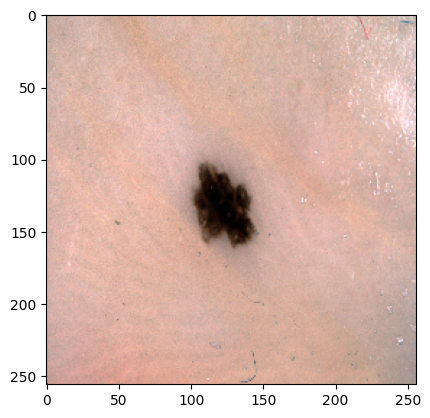

(None, 1.0, 0.0)

In [11]:
import matplotlib.pyplot as plt
plt.imshow(train_sample_img.transpose(1,2,0))
plt.show(),train_sample_img.max(),train_sample_img.min()

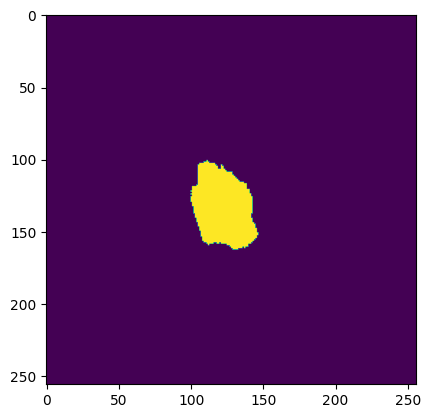

(None, 1.0, 0.0)

In [12]:
plt.imshow(train_sample_mask.transpose(1,2,0))
plt.show(),train_sample_mask.max(),train_sample_mask.min()

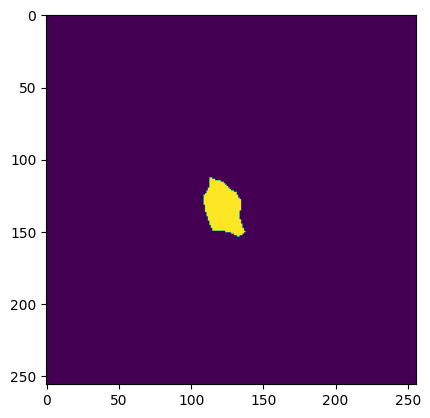

(None, 1.0, 0.0)

In [13]:
import matplotlib.pyplot as plt
plt.imshow(train_sample_shrinks.transpose(1,2,0))
plt.show(),train_sample_shrinks.max(),train_sample_shrinks.min()

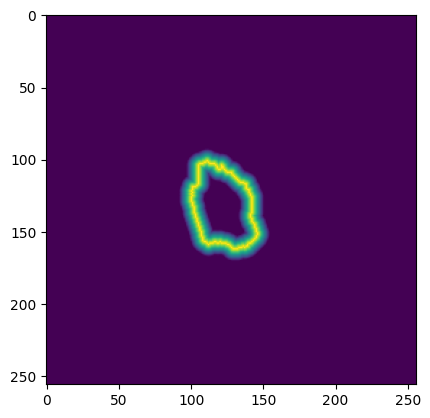

(None, 0.70000005, 0.3)

In [14]:
import matplotlib.pyplot as plt
plt.imshow(train_sample_thresholds.transpose(1,2,0))
plt.show(),train_sample_thresholds.max(),train_sample_thresholds.min()

In [15]:
np.concatenate((train_sample_mask,train_sample_shrinks,train_sample_thresholds),axis=0)[0:1,:,:].shape

(1, 256, 256)

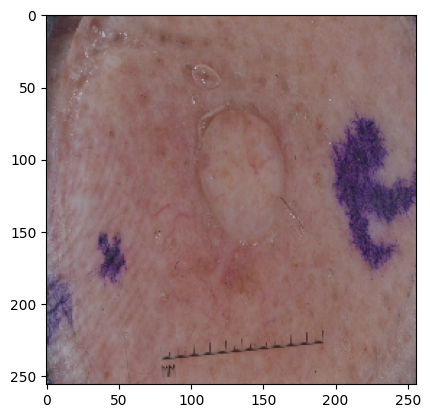

(None, 0.87496936, 0.09880515)

In [16]:
valid_sample_img = np.load(os.path.join('./datasets','ISIC','images',valid_img_ids[0]))
valid_sample_mask = np.load(os.path.join('./datasets','ISIC','masks',valid_img_ids[0]))
import matplotlib.pyplot as plt
plt.imshow(valid_sample_img.transpose(1,2,0))
plt.show(),valid_sample_img.max(),valid_sample_img.min()

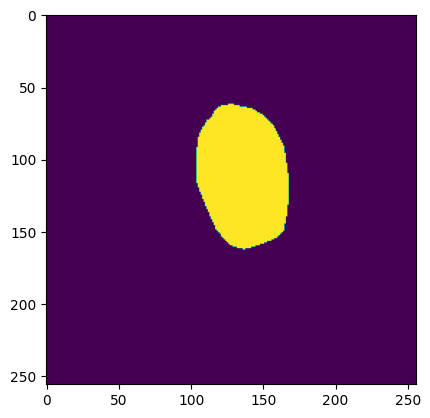

(None, 1.0, 0.0)

In [17]:
plt.imshow(valid_sample_mask.transpose(1,2,0))
plt.show(),valid_sample_mask.max(),valid_sample_mask.min()

模型图

In [16]:
valid_img_ids = np.load(os.path.join('./datasets','ISIC','valid_img_ids.npy'))
arr_list = valid_img_ids.tolist()
print(arr_list.index('ISIC_0000056.npy'))

363


In [17]:
train_img_ids = np.load(os.path.join('./datasets','ISIC','train_img_ids.npy'))
valid_img_ids = np.load(os.path.join('./datasets','ISIC','valid_img_ids.npy'))

In [18]:
idx=363
train_img_ids[idx]
train_img_ids = valid_img_ids

In [19]:
train_sample_img = np.load(os.path.join('./datasets','ISIC','images',train_img_ids[idx]))
train_sample_mask = np.load(os.path.join('./datasets','ISIC','masks',train_img_ids[idx]))
train_sample_shrinks = np.load(os.path.join('./datasets','ISIC','shrinks',train_img_ids[idx]))
train_sample_thresholds = np.load(os.path.join('./datasets','ISIC','thresholds',train_img_ids[idx]))

In [20]:
train_sample_img.shape,train_sample_mask.shape,train_sample_shrinks.shape,train_sample_thresholds.shape

((3, 256, 256), (1, 256, 256), (1, 256, 256), (1, 256, 256))

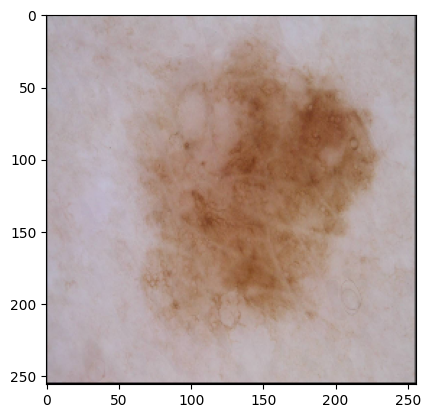

(None, 0.8190818, 0.0)

In [21]:
import matplotlib.pyplot as plt
plt.imshow(train_sample_img.transpose(1,2,0))
plt.show(),train_sample_img.max(),train_sample_img.min()

(256, 256) 197


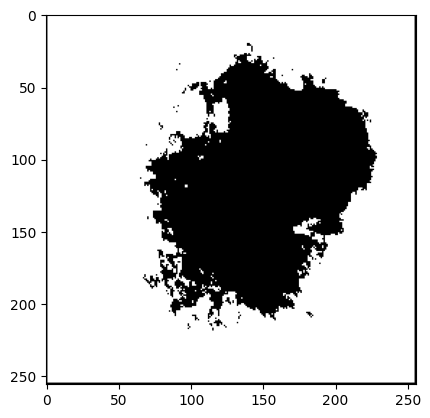

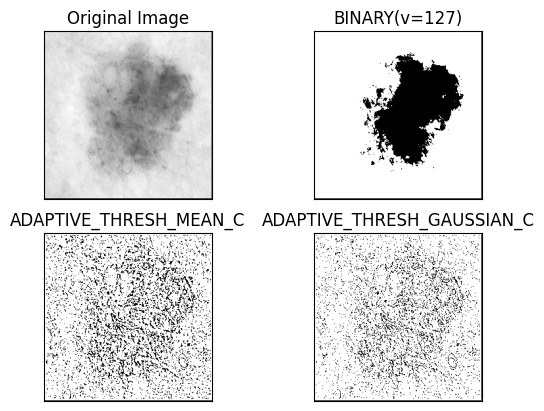

In [24]:
import cv2 as cv
from matplotlib import pyplot as plt
img = train_sample_img.transpose(1,2,0)*255.0
img = np.uint8(img)
img= cv.cvtColor(img, cv.COLOR_BGR2GRAY)
print(img.shape,img.max())
ret, th1 = cv.threshold(img, 127, 255, cv.THRESH_BINARY)
th2 = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 5, 3)
th3 = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 5, 3)
t2,otsu = cv2.threshold(img,127,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(otsu,cmap='gray')
plt.show()
titles = ['Original Image', 'BINARY(v=127)',
          'ADAPTIVE_THRESH_MEAN_C', 'ADAPTIVE_THRESH_GAUSSIAN_C']
images = [img, th1, th2, th3]
for i in range(4):
    plt.subplot(2, 2, i + 1), plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])
plt.show()


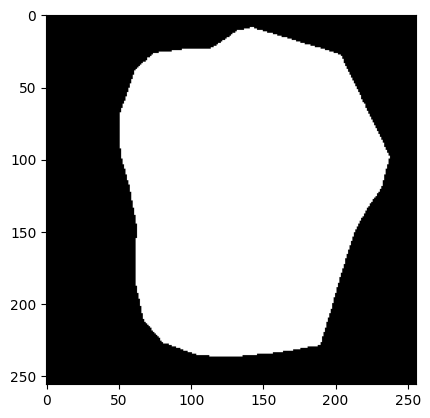

(None, 1.0, 0.0)

In [25]:
plt.imshow(train_sample_mask.transpose(1,2,0),cmap='gray')
plt.show(),train_sample_mask.max(),train_sample_mask.min()

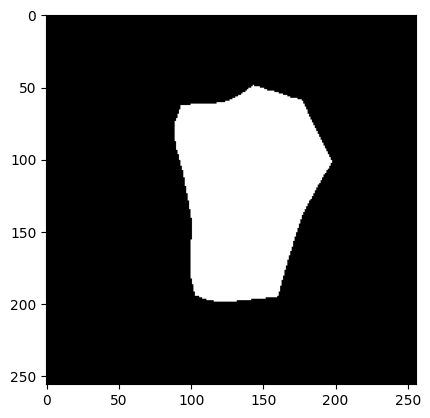

(None, 1.0, 0.0)

In [26]:
import matplotlib.pyplot as plt
plt.imshow(train_sample_shrinks.transpose(1,2,0),cmap='gray')
plt.show(),train_sample_shrinks.max(),train_sample_shrinks.min()

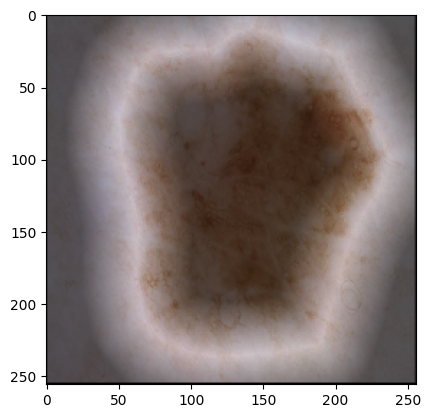

(256, 256) 198


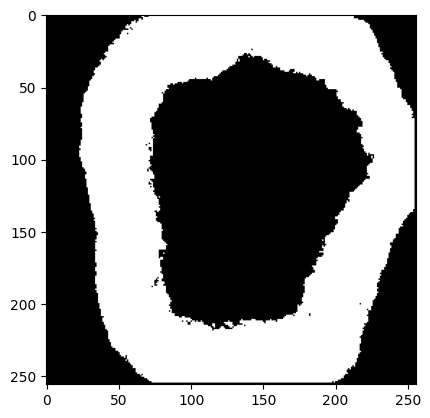

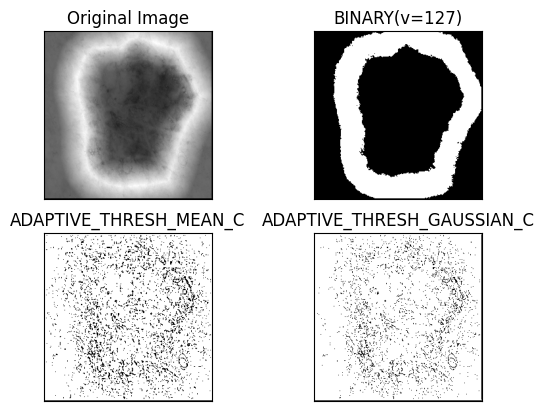

In [27]:
import matplotlib.pyplot as plt
# sample_test = train_sample_thresholds.transpose(1,2,0)*0.6+train_sample_img.transpose(1,2,0)
sample_test = train_sample_thresholds.transpose(1,2,0)*1.5*train_sample_img.transpose(1,2,0)

plt.imshow(sample_test,cmap='gray')
plt.show(),train_sample_thresholds.max(),train_sample_thresholds.min()

import cv2 as cv
from matplotlib import pyplot as plt
img = sample_test*255.0
img = np.uint8(img)
img= cv.cvtColor(img, cv.COLOR_BGR2GRAY)
print(img.shape,img.max())
ret, th1 = cv.threshold(img, 127, 255, cv.THRESH_BINARY)
th2 = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 5, 3)
th3 = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 5, 3)
t2,otsu = cv2.threshold(img,127,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(otsu,cmap='gray')
plt.show()
titles = ['Original Image', 'BINARY(v=127)',
          'ADAPTIVE_THRESH_MEAN_C', 'ADAPTIVE_THRESH_GAUSSIAN_C']
images = [img, th1, th2, th3]
for i in range(4):
    plt.subplot(2, 2, i + 1), plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])
plt.show()

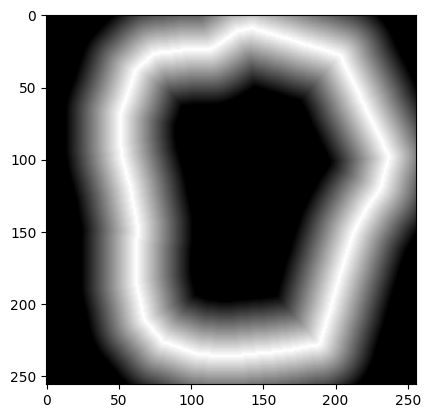

(None, 0.70000005, 0.3)

In [29]:
import matplotlib.pyplot as plt
plt.imshow(train_sample_thresholds.transpose(1,2,0),'gray')
plt.show(),train_sample_thresholds.max(),train_sample_thresholds.min()

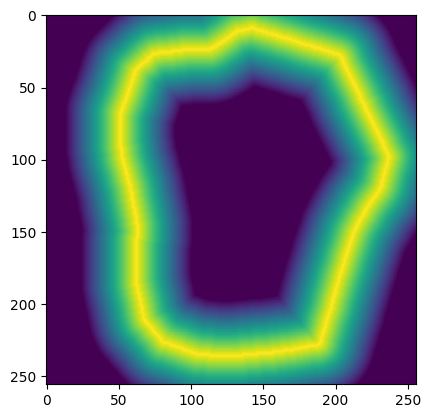

(None, 0.70000005, 0.3)

In [64]:
import matplotlib.pyplot as plt
plt.imshow(train_sample_thresholds.transpose(1,2,0))
plt.show(),train_sample_thresholds.max(),train_sample_thresholds.min()

(256, 256, 1) 178


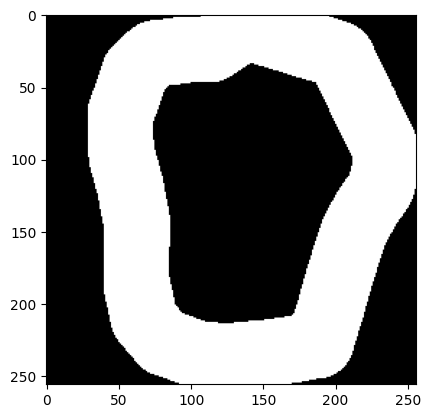

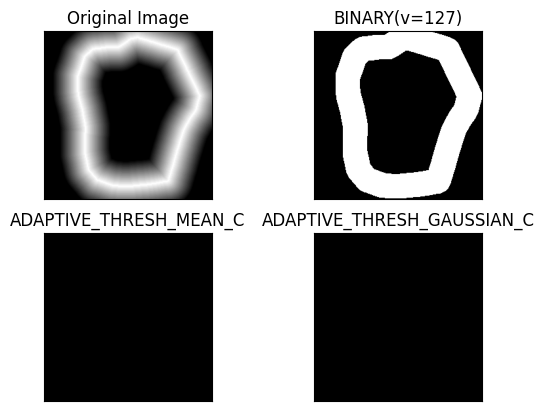

In [63]:
import cv2 as cv
from matplotlib import pyplot as plt
img = train_sample_thresholds.transpose(1,2,0)*255.0
img = np.uint8(img)
# img= cv.cvtColor(img, cv.COLOR_BGR2GRAY)
print(img.shape,img.max())
ret, th1 = cv.threshold(img, 127, 255, cv.THRESH_BINARY)
th2 = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 5, 3)
th3 = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 5, 3)
t2,otsu = cv2.threshold(img,127,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(otsu,cmap='gray')
plt.show()
titles = ['Original Image', 'BINARY(v=127)',
          'ADAPTIVE_THRESH_MEAN_C', 'ADAPTIVE_THRESH_GAUSSIAN_C']
images = [img, th1, th2, th3]
for i in range(4):
    plt.subplot(2, 2, i + 1), plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])
plt.show()

In [33]:
from skimage import measure
import cv2
from skimage import feature
mask_2d = (mask[0] == 1)
contours = measure.find_contours(mask_2d, 0.5)
if len(contours) > 1:
    contours = [contours[0]]
contours = np.array(contours)
contours1 = contours.copy()
contours1[:,:,1] = contours[:,:,0]
contours1[:,:,0] = contours[:,:,1]

NameError: name 'mask' is not defined

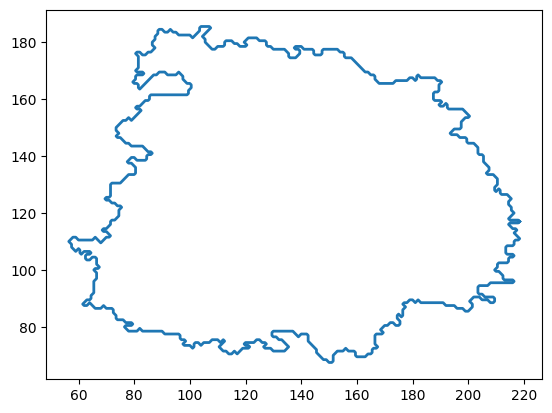

In [23]:
for contour in contours1:
    plt.plot(contour[:,1],contour[:,0],linewidth=2)
    plt.show()